# Artificial Minds at Work: Surveying with Large Language Models

This notebook analyzes data generated from LLMs for use as survey respondents.

### Persona Comparisons and Trends Analysis:
Here we will compare attributes of the generated personas to look for differences between models and to compare to current software engineering demographic trends.

# Experimental Setup 2

In [1]:
# @title
import pandas as pd
import numpy as np
import requests, zipfile, shutil, os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, spearmanr

# Create a blank DataFrame with the specified columns
#df = pd.DataFrame(columns=columns)
respondents = []

############################ Functions #########################################
# def chi_squared_test(column, df1, df2, label1="respondents", label2="survey CSV"):

#      # Calculate the frequency counts for the chosen column in both DataFrames
#     counts1 = df1[column].value_counts()
#     counts2 = df2[column].value_counts()

#     # Get the union of all categories and sort them by their string representation
#     categories = sorted(set(counts1.index).union(set(counts2.index)), key=lambda x: str(x))

#     # Build frequency vectors for each DataFrame based on the common categories
#     vector1 = [counts1.get(cat, 0) for cat in categories]
#     vector2 = [counts2.get(cat, 0) for cat in categories]

#     # Create the contingency table: rows correspond to the two groups
#     contingency_table = np.array([vector1, vector2])
#     print(f"\nContingency Table for '{column}' (rows: {label1}, {label2}):")
#     print(pd.DataFrame(contingency_table, columns=categories, index=[label1, label2]))

#     # Run the chi-squared test
#     chi2, p_value, dof, expected = chi2_contingency(contingency_table)

#     # Print the results
#     print(f"\nChi-Squared Test Results for '{column}':")
#     print(f"Chi2 Statistic: {chi2:.3f}")
#     print(f"Degrees of Freedom: {dof}")
#     print(f"P-value: {p_value:.3g}")
#     print("Expected Frequencies:")
#     print(expected)

# ChatGPT generated mapping functions
def map_remote(val):
    if pd.isnull(val):
        return False
    val_lower = val.lower()
    if "fully remote" in val_lower or "fully" in val_lower:
        return True
    else:
        return False

def map_education(ed_val):
    if pd.isnull(ed_val):
        return "Something else"
    ed_val_lower = ed_val.lower()
    if "bachelor" in ed_val_lower:
        return "Bachelor’s degree"
    elif "master" in ed_val_lower:
        return "Master’s degree"
    elif "professional" in ed_val_lower or "doctoral" in ed_val_lower or "phd" in ed_val_lower:
        return "Pro. Degree"
    elif "some college" in ed_val_lower or "associate" in ed_val_lower:
        return "Some college/uni study w/o earning a degree"
    else:
        return "Something else"

def map_years(val):
    if pd.isnull(val):
        return "Something else"
    val = str(val).lower().strip()
    if "less than 1" in val:
        return "Less than 1 year"
    elif "more than 50" in val:
        return "More than 50 years"
    else:
        try:
            yrs = float(val)
            if yrs < 1:
                return "Less than 1 year"
            elif yrs < 5:
                return "1 to 4 years"
            elif yrs < 10:
                return "5 to 9 years"
            elif yrs < 15:
                return "10 to 14 years"
            elif yrs < 20:
                return "15 to 19 years"
            elif yrs < 25:
                return "20 to 24 years"
            elif yrs < 30:
                return "25 to 29 years"
            elif yrs < 35:
                return "30 to 34 years"
            elif yrs < 40:
                return "35 to 39 years"
            elif yrs < 45:
                return "40 to 44 years"
            elif yrs < 50:
                return "45 to 49 years"
            else:
                return "More than 50 years"
        except:
            return "Something else"

# Ajinkya Change
# def map_years(val):
#   if pd.isnull(val):
#     return "Something else"
#   return val


def map_devtype(dev_val):
    if pd.isnull(dev_val):
        return "Something else"
    roles = dev_val.split(";")
    return roles[0].strip()

# Ajinkya Change

# def map_age_group(age):
#   print(age)
#   if pd.isnull(age):
#     return "Prefer not to say"
#   try:
#       age_num = float(age)
#       if age_num < 18:
#           return "Under 18 years old"
#       elif 18 <= age_num <= 24:
#           return "18-24 years old"
#       elif 25 <= age_num <= 34:
#           return "25-34 years old"
#       elif 35 <= age_num <= 44:
#           return "35-44 years old"
#       elif 45 <= age_num <= 54:
#           return "45-54 years old"
#       elif 55 <= age_num <= 64:
#           return "55-64 years old"
#       else:
#           return "65 years or older"
#   except:
#       return "Prefer not to say"

# Ajinkya Change
def map_age_group(age):
  #print(age)
  if pd.isnull(age):
    return "Prefer not to say"
  try:
      if age == "Under 18 years old" or age == "Under 18 years old":
          return "Under 18 years old"
      elif age == "18-24 years old" or age == "18 to 24 years old":
          return "18 to 24 years old"
      elif age == "25-34 years old" or age == "25 to 34 years old":
          return "25 to 34 years old"
      elif age == "35-44 years old" or age == "35 to 44 years old":
          return "35-44 years old"
      elif age == "45-54 years old" or age == "45 to 54 years old":
          return "45 to 54 years old"
      elif age == "55-64 years old" or age == "55 to 64 years old":
          return "55 to 64 years old"
      else:
          return " 65 years or older"
  except:
      return "Prefer not to say"

def parse_pro_experience(exp_str):
    exp_mapping = {
        "Less than 1 year": 0.5,
        "1 to 4 years": 2.5,
        "5 to 9 years": 7,
        "10 to 14 years": 12,
        "15 to 19 years": 17,
        "20 to 24 years": 22,
        "25 to 29 years": 27,
        "30 to 34 years": 32,
        "35 to 39 years": 37,
        "40 to 44 years": 42,
        "45 to 49 years": 47,
        "More than 50 years": 50  # Assuming 50 as a conservative minimum
    }
    return exp_mapping.get(str(exp_str), None)

def parse_years_coding(exp_str):
    exp_mapping = {
        "Less than 1 year": 0.5,
        "1 to 4 years": 2.5,
        "5 to 9 years": 7,
        "10 to 14 years": 12,
        "15 to 19 years": 17,
        "20 to 24 years": 22,
        "25 to 29 years": 27,
        "30 to 34 years": 32,
        "35 to 39 years": 37,
        "40 to 44 years": 42,
        "45 to 49 years": 47,
        "More than 50 years": 50  # Assuming 50 as a conservative minimum
    }
    return exp_mapping.get(str(exp_str), None)

def parse_age_group(age_str):
    if not isinstance(age_str, str):
        return None
    age_str = age_str.lower()
    if "under 18" in age_str:
        return 16
    elif "18-24" in age_str:
        return 21
    elif "25-34" in age_str:
        return 29
    elif "35 to 44" in age_str:
        return 39
    elif "45 to 54" in age_str:
        return 50
    elif "55 to 64" in age_str:
        return 60
    elif "65" in age_str:
        return 68
    else:
        return None

import math
def define_expert(exp_str):
    # Check if the input is NaN or None
    if exp_str is None or (isinstance(exp_str, float) and math.isnan(exp_str)):
        return "Other"
    try:
        exp_int = int(float(exp_str))
    except ValueError:
        return "Other"

    if exp_int >= 10:
        return "Expert"
    elif exp_int >= 5:
        return "Intermediate"
    elif exp_int < 5:
        return "Novice"
    else:
        return "Other"

def check_consistency(age_num, total_years, prof_years):
    try:
        # Convert values to float first, handle invalid values
        age_num = float(age_num)
        total_years = float(total_years)
        prof_years = float(prof_years)
    except (ValueError, TypeError):
        return True  # If any value is non-numeric, assume consistency

    # 1) Professional <= total
    if prof_years > total_years:
        return False

    # 2) total_years <= (age_num - min_start_age), assuming earliest coding start is age 10
    if total_years > (age_num - 10):
        return False

    # 3) Professional experience shouldn't start before age 14
    if prof_years > (age_num - 14):
        return False

    return True  # If all checks pass

def validate_row(row):
    age_num = row["age_numeric"]
    total_yrs = row["total_coding_years_numeric"]
    prof_yrs = row["prof_exp_numeric"]
    return check_consistency(age_num, total_yrs, prof_yrs)


### GPT-4 Respondents

In [2]:
# @title
respondents.extend([
{"model": "GPT-4", "name": "Alice Thompson", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Full-stack", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Michael Carter", "age": 42, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media", "On-the-job training"], "online_resources": ["Written Tutorials", "Online challenges", "Technical documentation"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.8, "primary_job": "Data Engineer", "survey_country": "Canada", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Samantha Lee", "age": 24, "gender": "Non-binary", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Online challenges", "A friend or family member"], "online_resources": ["AI", "Interactive tutorial", "Stack Overflow", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.8, "primary_job": "Front-end", "survey_country": "United Kingdom", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Robert Chen", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["E-courses or Certification", "School", "Colleague"], "online_resources": ["Blogs", "How-to videos", "Video-based E-courses", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.1, "primary_job": "Security pro.", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Emily Davis", "age": 47, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "E-courses or Certification", "On-the-job training"], "online_resources": ["Written-based E-courses", "Stack Overflow", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.7, "primary_job": "DevOps Specialist", "survey_country": "France", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Carlos Rodriguez", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["A friend or family member", "Online challenges", "Other online resources"], "online_resources": ["Games that teach programming", "Online books", "Blogs", "Technical documentation"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.3, "primary_job": "AI", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Isabella Martinez", "age": 22, "gender": "Female", "remote": False, "survey_education_level": "Secondary school", "learning_methods": ["Coding Bootcamp", "E-courses or Certification"], "online_resources": ["Interactive tutorial", "Online challenges", "How-to videos"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.9, "primary_job": "Student", "survey_country": "Mexico", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "David Nguyen", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "Colleague", "Technical documentation"], "online_resources": ["Certification videos", "Stack Overflow", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository", "API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "Cloud infra. Engineer", "survey_country": "Australia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Omar Ali", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Written-based E-courses", "Technical documentation", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.8, "primary_job": "Sci.", "survey_country": "Egypt", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Ethan Walker", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.5, "primary_job": "DevOps Specialist", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Sophia Johnson", "age": 27, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Books / Physical media", "Colleague", "School"], "online_resources": ["Video-based E-courses", "Social Media", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.9, "primary_job": "Full-stack", "survey_country": "Canada", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ava Patel", "age": 23, "gender": "Female", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "How-to videos"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "India", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Noah Garcia", "age": 56, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Other online resources", "Books / Physical media", "E-courses or Certification"], "online_resources": ["Technical documentation", "Stack Overflow", "AI"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.1, "primary_job": "AI", "survey_country": "Spain", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Lucas Brown", "age": 39, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Certification videos", "How-to videos", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.8, "primary_job": "Security pro.", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Emma Wilson", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["E-courses or Certification", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Online books", "Interactive tutorial"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "DevOps Specialist", "survey_country": "United Kingdom", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "William Martin", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Technical documentation"], "technical_documentation_sources": ["User guides or README files found in the source repository", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.5, "primary_job": "Academic researcher", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Olivia Lewis", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Coding sessions"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.7, "primary_job": "Games", "survey_country": "Germany", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Daniel Scott", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Other online resources", "Books / Physical media"], "online_resources": ["How-to videos", "Social Media", "AI"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.2, "primary_job": "Data sci. or ML specialist", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Michael Thompson", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Stack Overflow", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Alex Kim", "age": 24, "gender": "Non-binary", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["E-courses or Certification", "Coding Bootcamp"], "online_resources": ["AI", "Online challenges", "Games that teach programming"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.8, "primary_job": "Full-stack", "survey_country": "South Korea", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Rajesh Patel", "age": 41, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs", "Video-based E-courses"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.5, "primary_job": "Security pro.", "survey_country": "India", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Emma Watson", "age": 50, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Books / Physical media", "A friend or family member"], "online_resources": ["Written-based E-courses", "Auditory material", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "API document and/or SDK document"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.3, "primary_job": "Academic researcher", "survey_country": "United Kingdom", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Liam O'Connor", "age": 37, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.1, "primary_job": "Cloud infra. Engineer", "survey_country": "Ireland", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Isabella Rossi", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["How-to videos", "Social Media", "Online challenges"], "technical_documentation_sources": ["First-party knowledge base", "API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "AI", "survey_country": "Italy", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Noah Smith", "age": 27, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Stack Overflow", "Certification videos", "Coding sessions"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.3, "primary_job": "Front-end", "survey_country": "Australia", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Emily Chen", "age": 23, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["A friend or family member", "On-the-job training"], "online_resources": ["Written Tutorials", "Blogs", "Games that teach programming"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Mobile", "survey_country": "Singapore", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Emma Johnson", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Books / Physical media"], "online_resources": ["Technical documentation", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.2, "primary_job": "Data sci. or ML specialist", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Liam Smith", "age": 35, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Stack Overflow", "Online books", "Certification videos"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.3, "primary_job": "Full-stack", "survey_country": "Canada", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Olivia Wang", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Technical documentation", "How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.1, "primary_job": "DevOps Specialist", "survey_country": "Australia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Noah Miller", "age": 23, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["A friend or family member", "Other online resources"], "online_resources": ["Games that teach programming", "Online challenges", "Interactive tutorial"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.8, "primary_job": "Games", "survey_country": "United Kingdom", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "James O'Connor", "age": 56, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository", "First-party knowledge base"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.7, "primary_job": "Embed Dev Experience", "survey_country": "Ireland", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Isabella Tan", "age": 21, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Written Tutorials", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Student", "survey_country": "Singapore", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Alexander Petrovski", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Stack Overflow", "Video-based E-courses", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "API document and/or SDK document"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.3, "primary_job": "Back-end", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Fatima Hassan", "age": 34, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "E-courses or Certification", "Colleague"], "online_resources": ["Technical documentation", "Online books", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.4, "primary_job": "Cloud infra. Engineer", "survey_country": "United Arab Emirates", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Mia Rodriguez", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["How-to videos", "Video-based E-courses", "AI"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.3, "primary_job": "Data sci. or ML specialist", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Abdul Rahman", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Certification videos", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.5, "primary_job": "Security pro.", "survey_country": "Saudi Arabia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Elena Ivanova", "age": 37, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books", "Written-based E-courses"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.2, "primary_job": "Cloud infra. Engineer", "survey_country": "Russia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Ethan Baker", "age": 30, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Stack Overflow", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "Games", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Lucas Moreira", "age": 38, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["Other online resources", "Colleague"], "online_resources": ["Technical documentation", "Social Media", "AI"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.8, "primary_job": "DevOps Specialist", "survey_country": "Brazil", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Anna Kowalska", "age": 34, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Online challenges"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.4, "primary_job": "Data Engineer", "survey_country": "Poland", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "William Brown", "age": 60, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Certification videos"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "35 to 39 years", "professional_coding_experience": 38.1, "primary_job": "Embed Dev Experience", "survey_country": "United Kingdom", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Lucas Wright", "age": 32, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.5, "primary_job": "Back-end", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Isabella Chen", "age": 27, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Data sci. or ML specialist", "survey_country": "Canada", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ethan Patel", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.3, "primary_job": "Security pro.", "survey_country": "India", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sophia Müller", "age": 38, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.4, "primary_job": "Full-stack", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Noah Thompson", "age": 21, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.8, "primary_job": "Student", "survey_country": "United Kingdom", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Amara Williams", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.1, "primary_job": "Cloud infra. Engineer", "survey_country": "Australia", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Omar El-Sayed", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.5, "primary_job": "AI", "survey_country": "Egypt", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Liam Rodríguez", "age": 24, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Games", "survey_country": "Mexico", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Jasmine Lee", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.7, "primary_job": "Academic researcher", "survey_country": "South Korea", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Elijah Carter", "age": 35, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.9, "primary_job": "Front-end", "survey_country": "New Zealand", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Ethan Williams", "age": 28, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.3, "primary_job": "Full-stack", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Isabella Schmidt", "age": 33, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["How-to videos", "AI", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.1, "primary_job": "Data sci. or ML specialist", "survey_country": "Germany", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Nathaniel Kim", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.5, "primary_job": "Security pro.", "survey_country": "South Korea", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sophia Mendes", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Stack Overflow", "How-to videos", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.8, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Oliver Dubois", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.9, "primary_job": "AI", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Amira Khan", "age": 23, "gender": "Female", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Games that teach programming", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.2, "primary_job": "Games", "survey_country": "United Arab Emirates", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Jack O'Connor", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.4, "primary_job": "Cloud infra. Engineer", "survey_country": "Ireland", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Aiden McCarthy", "age": 30, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Back-end", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Brianna O'Neil", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Front-end", "survey_country": "Canada", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Cameron Foster", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Stack Overflow"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "United Kingdom", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Diana Alvarez", "age": 35, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.3, "primary_job": "Full-stack", "survey_country": "Spain", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Ethan Russo", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Video-based E-courses"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Security pro.", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Fiona Zhang", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "School"], "online_resources": ["Written Tutorials", "Online books"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Data sci. or ML specialist", "survey_country": "China", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Gabriel Hernandez", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Blogs"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.8, "primary_job": "Back-end", "survey_country": "Mexico", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Harper Schmidt", "age": 22, "gender": "Non-binary", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Games that teach programming", "Technical documentation"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Student", "survey_country": "Germany", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Ian Nakamura", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Interactive tutorial", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.0, "primary_job": "Full-stack", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Jade Laurent", "age": 28, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["How-to videos", "Online challenges"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.8, "primary_job": "Front-end", "survey_country": "France", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Kevin Patel", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.2, "primary_job": "DevOps Specialist", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Lily Thompson", "age": 19, "gender": "Female", "remote": False, "survey_education_level": "Secondary school", "learning_methods": ["School", "A friend or family member"], "online_resources": ["Video-based E-courses", "Social Media"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.8, "primary_job": "Student", "survey_country": "United Kingdom", "age_group": "Under 18 years old"},
{"model": "GPT-4", "name": "Marcus Silva", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 15.5, "primary_job": "Sys", "survey_country": "Brazil", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Nora Johansson", "age": 31, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Online books", "Blogs"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.9, "primary_job": "Data Engineer", "survey_country": "Sweden", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Oliver Rossi", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Manager", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Penelope Kim", "age": 23, "gender": "Female", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Written Tutorials", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Student", "survey_country": "South Korea", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Quentin Murphy", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Cloud infra. Engineer", "survey_country": "Ireland", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Riley Gupta", "age": 39, "gender": "Other", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "Technical documentation", "How-to videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 15.8, "primary_job": "QA Dev", "survey_country": "India", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Serena Novak", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Stack Overflow", "Blogs"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.9, "primary_job": "Front-end", "survey_country": "Poland", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Trevor Carter", "age": 44, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.2, "primary_job": "SRE", "survey_country": "Australia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Uma Singh", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.7, "primary_job": "Data sci. or ML specialist", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Victor Lee", "age": 41, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 15.0, "primary_job": "Data Engineer", "survey_country": "Singapore", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Wendy Brooks", "age": 48, "gender": "Female", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.3, "primary_job": "Manager", "survey_country": "United States", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Xavier Dubois", "age": 29, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Games that teach programming", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.2, "primary_job": "Student", "survey_country": "France", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Yasmine El-Amin", "age": 38, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.9, "primary_job": "Cloud infra. Engineer", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Zachary Bennett", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.5, "primary_job": "Sys", "survey_country": "Australia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Amelia Fraser", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Secondary school", "learning_methods": ["School", "A friend or family member"], "online_resources": ["How-to videos", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.3, "primary_job": "Student", "survey_country": "New Zealand", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Benjamin Cole", "age": 46, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 15.4, "primary_job": "Back-end", "survey_country": "United States", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Chloe Wright", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "Online challenges"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.2, "primary_job": "DevOps Specialist", "survey_country": "United Kingdom", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Daniel Moore", "age": 55, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Manager", "survey_country": "Ireland", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Evelyn Garcia", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.7, "primary_job": "Student", "survey_country": "Spain", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Finn Johansson", "age": 34, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.4, "primary_job": "Full-stack", "survey_country": "Sweden", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Grace Parker", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "School"], "online_resources": ["Online books", "Technical documentation"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.9, "primary_job": "Data Engineer", "survey_country": "Netherlands", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Henry Evans", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.7, "primary_job": "Manager", "survey_country": "United States", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Iris Martin", "age": 23, "gender": "Non-binary", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Interactive tutorial", "How-to videos"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.1, "primary_job": "Student", "survey_country": "Denmark", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Jack Robinson", "age": 38, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.3, "primary_job": "DevOps Specialist", "survey_country": "Australia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Kira Sato", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.7, "primary_job": "Front-end", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Liam Donovan", "age": 35, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "School"], "online_resources": ["Online books", "How-to videos"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.0, "primary_job": "Back-end", "survey_country": "United States", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Maya Schmidt", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "QA Dev", "survey_country": "Germany", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Nolan Perez", "age": 43, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "Data sci. or ML specialist", "survey_country": "United States", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Aaron Caldwell", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.3, "primary_job": "Back-end", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Bianca Navarro", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.8, "primary_job": "Data sci. or ML specialist", "survey_country": "Canada", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Carter Higgins", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.1, "primary_job": "Security pro.", "survey_country": "United Kingdom", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Daphne Laurent", "age": 38, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "Full-stack", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Eli Patterson", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.9, "primary_job": "Student", "survey_country": "Australia", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Fiona Park", "age": 31, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.2, "primary_job": "Cloud infra. Engineer", "survey_country": "South Korea", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Gabriel Moretti", "age": 52, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.3, "primary_job": "AI", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Holly Andersen", "age": 25, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.2, "primary_job": "Games", "survey_country": "Denmark", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Ian Nakamoto", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.5, "primary_job": "Academic researcher", "survey_country": "Japan", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Jessica Doyle", "age": 37, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.4, "primary_job": "Front-end", "survey_country": "Ireland", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Oliver Jensen", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "E-courses or Certification"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Full-stack", "survey_country": "Denmark", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Amira Patel", "age": 33, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["How-to videos", "AI", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.3, "primary_job": "Data sci. or ML specialist", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Lucas Moreau", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.7, "primary_job": "Security pro.", "survey_country": "France", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sophia Liu", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Stack Overflow", "How-to videos", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Back-end", "survey_country": "China", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Noah Fischer", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.8, "primary_job": "AI", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Hassan Mahmoud", "age": 23, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Games that teach programming", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.3, "primary_job": "Games", "survey_country": "Egypt", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Carla Rojas", "age": 34, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Technical documentation", "Stack Overflow", "How-to videos"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.2, "primary_job": "Data Engineer", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Adrian Silva", "age": 28, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.4, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Bella Laurent", "age": 34, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.1, "primary_job": "Data sci. or ML specialist", "survey_country": "France", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Caleb Peterson", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.8, "primary_job": "Security pro.", "survey_country": "United States", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Diana Rosales", "age": 30, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.7, "primary_job": "Full-stack", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Elias Cheng", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.4, "primary_job": "Student", "survey_country": "Canada", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Farah Jassim", "age": 36, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "Cloud infra. Engineer", "survey_country": "United Arab Emirates", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Gideon Nowak", "age": 54, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.0, "primary_job": "AI", "survey_country": "Poland", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Hana Tanaka", "age": 27, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.3, "primary_job": "Games", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Imani Osei", "age": 45, "gender": "Female", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.1, "primary_job": "Academic researcher", "survey_country": "Ghana", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Liam Anderson", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.4, "primary_job": "Full-stack", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Emma Becker", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["How-to videos", "AI", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.9, "primary_job": "Data sci. or ML specialist", "survey_country": "Germany", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Noah Martinez", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.3, "primary_job": "Security pro.", "survey_country": "South Korea", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sophia Chang", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Stack Overflow", "How-to videos", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Oliver Moreau", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.8, "primary_job": "AI", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Amira Hassan", "age": 23, "gender": "Female", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Games that teach programming", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.4, "primary_job": "Games", "survey_country": "United Arab Emirates", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Jack O'Connell", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.9, "primary_job": "Cloud infra. Engineer", "survey_country": "Ireland", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Carla Rodriguez", "age": 34, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Technical documentation", "Stack Overflow", "How-to videos"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.2, "primary_job": "Data Engineer", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "James Mitchell", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "E-courses or Certification"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.3, "primary_job": "Full-stack", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Amelia Ricci", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["How-to videos", "AI", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Data sci. or ML specialist", "survey_country": "Italy", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Nathaniel Young", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.8, "primary_job": "Security pro.", "survey_country": "United Kingdom", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sophia Tanaka", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Stack Overflow", "How-to videos", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Oliver Dupont", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.9, "primary_job": "AI", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Ahmed Khan", "age": 23, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Games that teach programming", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.1, "primary_job": "Games", "survey_country": "Pakistan", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Carla Fernandez", "age": 34, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Technical documentation", "Stack Overflow", "How-to videos"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.1, "primary_job": "Data Engineer", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Elena Petrova", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Social Media"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.7, "primary_job": "DevOps Specialist", "survey_country": "Russia", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Adam Kowalski", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "Poland", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Beatriz Oliveira", "age": 33, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Carlos Mendez", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.7, "primary_job": "Security pro.", "survey_country": "Mexico", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Daniela Rossi", "age": 37, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.3, "primary_job": "Full-stack", "survey_country": "Italy", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Elijah Thompson", "age": 24, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.8, "primary_job": "Student", "survey_country": "United States", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Fatima Hussain", "age": 41, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.2, "primary_job": "Cloud infra. Engineer", "survey_country": "United Arab Emirates", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Gabriel Nowak", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.6, "primary_job": "AI", "survey_country": "Germany", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Hannah Lee", "age": 27, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.1, "primary_job": "Games", "survey_country": "South Korea", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ibrahim Al-Farsi", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.4, "primary_job": "Academic researcher", "survey_country": "Saudi Arabia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Jessica Müller", "age": 39, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "Front-end", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Sophia Martinez", "age": 27, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.8, "primary_job": "Data sci. or ML specialist", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Emeka Okafor", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.3, "primary_job": "Security pro.", "survey_country": "Nigeria", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Chiara Romano", "age": 38, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.4, "primary_job": "Full-stack", "survey_country": "Italy", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Fatima Zahra", "age": 40, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.5, "primary_job": "Cloud infra. Engineer", "survey_country": "Morocco", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Liam Petrov", "age": 51, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.1, "primary_job": "AI", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Hye-Jin Park", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Games", "survey_country": "South Korea", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ahmed Rafiq", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.7, "primary_job": "Academic researcher", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Jessica Novak", "age": 35, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.6, "primary_job": "Front-end", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Lucas Bernard", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.2, "primary_job": "Security pro.", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Sophia Vasquez", "age": 27, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "Coding Bootcamp"], "online_resources": ["Interactive tutorial", "Written-based E-courses", "Online books"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.4, "primary_job": "Front-end", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ethan Campbell", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Technical documentation", "Blogs", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Cloud infra. Engineer", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Oliver Zhang", "age": 22, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Online challenges", "Games that teach programming", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.7, "primary_job": "Games", "survey_country": "China", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Daniel Park", "age": 30, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Coding Bootcamp", "E-courses or Certification"], "online_resources": ["Written Tutorials", "Stack Overflow", "Interactive tutorial"], "technical_documentation_sources": ["AI-powered search/dev tool", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.3, "primary_job": "AI", "survey_country": "South Korea", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Javier Montes", "age": 27, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Stack Overflow", "Social Media", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.4, "primary_job": "Data Engineer", "survey_country": "Argentina", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Lina Novák", "age": 36, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Technical documentation", "Online books", "Blogs"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.1, "primary_job": "Security pro.", "survey_country": "Czech Republic", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Omar Hassan", "age": 44, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["How-to videos", "Written Tutorials", "Games that teach programming"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.5, "primary_job": "Full-stack", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Selena Kim", "age": 23, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Other online resources"], "online_resources": ["Interactive tutorial", "Online challenges", "Auditory material"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.2, "primary_job": "Games", "survey_country": "South Korea", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Giovanni Russo", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Certification videos"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.3, "primary_job": "Cloud infra. Engineer", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Anita Choudhury", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["A friend or family member", "On-the-job training"], "online_resources": ["AI", "How-to videos", "Social Media"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.1, "primary_job": "Mobile", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Viktor Petrov", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Colleague", "School"], "online_resources": ["Online books", "Certification videos", "Technical documentation"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "AI", "survey_country": "Russia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Hector Ramirez", "age": 31, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Social Media", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.2, "primary_job": "Back-end", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Elsa Bergstrom", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.7, "primary_job": "Data sci. or ML specialist", "survey_country": "Sweden", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ethan Caldwell", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "E-courses or Certification"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.3, "primary_job": "Full-stack", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Amira Rodríguez", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["How-to videos", "AI", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Data sci. or ML specialist", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Luca Moretti", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.8, "primary_job": "Security pro.", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Aisha Tanaka", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Stack Overflow", "How-to videos", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Noah Dupont", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.9, "primary_job": "AI", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Fatima Khan", "age": 23, "gender": "Female", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Games that teach programming", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.1, "primary_job": "Games", "survey_country": "Pakistan", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Jack O'Reilly", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.4, "primary_job": "Cloud infra. Engineer", "survey_country": "Ireland", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Carlos Fernández", "age": 34, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Technical documentation", "Stack Overflow", "How-to videos"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.1, "primary_job": "Data Engineer", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Rafael Oliveira", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "E-courses or Certification"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.4, "primary_job": "Full-stack", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Isabelle Laurent", "age": 28, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["How-to videos", "AI", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Data sci. or ML specialist", "survey_country": "France", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Viktor Ivanov", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.8, "primary_job": "Security pro.", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Mei Chen", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Stack Overflow", "How-to videos", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "China", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Jasper Müller", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.9, "primary_job": "AI", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Liam Patel", "age": 23, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Games that teach programming", "Interactive tutorial", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.1, "primary_job": "Games", "survey_country": "India", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Oliver McKenzie", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.4, "primary_job": "Cloud infra. Engineer", "survey_country": "United Kingdom", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Valentina Rojas", "age": 34, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Technical documentation", "Stack Overflow", "How-to videos"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.1, "primary_job": "Data Engineer", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Hassan Al-Mansour", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Technical documentation", "AI", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.4, "primary_job": "AI", "survey_country": "Saudi Arabia", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Elena Petrov", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Social Media"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.7, "primary_job": "DevOps Specialist", "survey_country": "Russia", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Jaxon Whitmore", "age": 28, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Back-end", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Isla Romanov", "age": 34, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.6, "primary_job": "Data sci. or ML specialist", "survey_country": "Russia", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Mateo Delgado", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.3, "primary_job": "Security pro.", "survey_country": "Spain", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Zahra Al-Mansouri", "age": 39, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.9, "primary_job": "Full-stack", "survey_country": "United Arab Emirates", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Dmitri Koslov", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.1, "primary_job": "Student", "survey_country": "Ukraine", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Ananya Kapoor", "age": 41, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.5, "primary_job": "Cloud infra. Engineer", "survey_country": "India", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Omar Saidani", "age": 55, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.1, "primary_job": "AI", "survey_country": "Tunisia", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Haru Takahashi", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.8, "primary_job": "Games", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Kwame Mensah", "age": 48, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.2, "primary_job": "Academic researcher", "survey_country": "Ghana", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Helene Dubois", "age": 35, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.9, "primary_job": "Front-end", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Lukas Schmidt", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.3, "primary_job": "Security pro.", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Aisha Mohammed", "age": 24, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "Coding Bootcamp"], "online_resources": ["Interactive tutorial", "Written-based E-courses", "Online books"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.1, "primary_job": "Front-end", "survey_country": "United Arab Emirates", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Carlos Fernandez", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Technical documentation", "Blogs", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.2, "primary_job": "Cloud infra. Engineer", "survey_country": "Spain", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Ethan Taylor", "age": 35, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Social Media", "How-to videos"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.9, "primary_job": "Data sci. or ML specialist", "survey_country": "United States", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Noah Kim", "age": 22, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["E-courses or Certification", "A friend or family member"], "online_resources": ["Online challenges", "Games that teach programming", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.8, "primary_job": "Games", "survey_country": "South Korea", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Sofia Martinez", "age": 45, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Certification videos", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.5, "primary_job": "Back-end", "survey_country": "Mexico", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Nathan Rossi", "age": 30, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Coding Bootcamp", "E-courses or Certification"], "online_resources": ["Written Tutorials", "Stack Overflow", "Interactive tutorial"], "technical_documentation_sources": ["AI-powered search/dev tool", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.9, "primary_job": "AI", "survey_country": "Italy", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Hassan Ibrahim", "age": 39, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "AI", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.8, "primary_job": "Security pro.", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Emily Fischer", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Colleague"], "online_resources": ["Technical documentation", "Video-based E-courses", "Blogs"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "DevOps Specialist", "survey_country": "Germany", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Kai Morrison", "age": 24, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.2, "primary_job": "Student", "survey_country": "New Zealand", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Elena Vasquez", "age": 35, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Chile", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Rohan Gupta", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.9, "primary_job": "Security pro.", "survey_country": "India", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Amara Diallo", "age": 38, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.3, "primary_job": "Full-stack", "survey_country": "Senegal", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Mikhail Petrov", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 31.8, "primary_job": "AI", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Fatima Al-Rashid", "age": 41, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.9, "primary_job": "Cloud infra. Engineer", "survey_country": "United Arab Emirates", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Johan Svensson", "age": 55, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.1, "primary_job": "Academic researcher", "survey_country": "Sweden", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Ayaka Tanaka", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.6, "primary_job": "Games", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Oluwaseun Adebayo", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.5, "primary_job": "Academic researcher", "survey_country": "Nigeria", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sofia Berg", "age": 35, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.3, "primary_job": "Front-end", "survey_country": "Denmark", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Dmitri Volkov", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.1, "primary_job": "Security pro.", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sofia Mendez", "age": 34, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "AI", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.3, "primary_job": "Full-stack", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Jared Cohen", "age": 29, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Written Tutorials", "Online books", "Interactive tutorial"], "technical_documentation_sources": ["User guides or README files found in the source repository", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Games", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Akira Nakamura", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Games that teach programming", "AI", "How-to videos"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.5, "primary_job": "AI", "survey_country": "Japan", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Lina Petrova", "age": 27, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "A friend or family member"], "online_resources": ["Online challenges", "Written-based E-courses", "Blogs"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.8, "primary_job": "Back-end", "survey_country": "Bulgaria", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Hassan Ali", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Certification videos", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.7, "primary_job": "Cloud infra. Engineer", "survey_country": "Pakistan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Oscar Lindholm", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Colleague", "School"], "online_resources": ["Technical documentation", "Online books", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.2, "primary_job": "Senior Executive", "survey_country": "Sweden", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Mia Johansson", "age": 23, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["How-to videos", "Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Student", "survey_country": "Norway", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Matteo Rossi", "age": 38, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.4, "primary_job": "AI", "survey_country": "Italy", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Carlos Ruiz", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Books / Physical media"], "online_resources": ["Technical documentation", "Stack Overflow", "Social Media"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.1, "primary_job": "Data Engineer", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Zainab Khalid", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "AI", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.4, "primary_job": "Security pro.", "survey_country": "United Arab Emirates", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Luis Hernandez", "age": 31, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Games that teach programming", "Online challenges", "AI"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Games", "survey_country": "Mexico", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ananya Das", "age": 42, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Blogs", "Certification videos"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "Cloud infra. Engineer", "survey_country": "India", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "David Kowalski", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Colleague", "School"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.1, "primary_job": "Full-stack", "survey_country": "Poland", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Amina Yusuf", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["E-courses or Certification", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Social Media", "How-to videos"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.7, "primary_job": "Back-end", "survey_country": "Nigeria", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Javier Morales", "age": 55, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 33.2, "primary_job": "Senior Executive", "survey_country": "Argentina", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Fatima Al-Farsi", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Games that teach programming", "Stack Overflow", "AI"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.3, "primary_job": "Blockchain", "survey_country": "Saudi Arabia", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Elijah Williams", "age": 39, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Online books", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.4, "primary_job": "AI", "survey_country": "United States", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Yuki Nakamura", "age": 27, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Other online resources", "Books / Physical media"], "online_resources": ["Technical documentation", "Stack Overflow", "Social Media"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.7, "primary_job": "Data Engineer", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Helena Petrovic", "age": 45, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Technical documentation", "AI", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.8, "primary_job": "Security pro.", "survey_country": "Serbia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Mateo Rojas", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.4, "primary_job": "Back-end", "survey_country": "Argentina", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Isabelle Fontaine", "age": 34, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.9, "primary_job": "Data sci. or ML specialist", "survey_country": "France", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Chen Wei", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.7, "primary_job": "Security pro.", "survey_country": "China", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Javier Torres", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.2, "primary_job": "Student", "survey_country": "Mexico", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Nia Mbatha", "age": 40, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "Cloud infra. Engineer", "survey_country": "South Africa", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Hassan Al-Farsi", "age": 55, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.4, "primary_job": "AI", "survey_country": "Oman", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Misaki Hayashi", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.1, "primary_job": "Games", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Abdulrahman Said", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.5, "primary_job": "Academic researcher", "survey_country": "Egypt", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Sophie Andersen", "age": 36, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.9, "primary_job": "Front-end", "survey_country": "Norway", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Felix Schmidt", "age": 32, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.8, "primary_job": "Back-end", "survey_country": "Germany", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Olivia Thompson", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Data sci. or ML specialist", "survey_country": "United Kingdom", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Emmanuel Okeke", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.1, "primary_job": "Security pro.", "survey_country": "Nigeria", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Lucia Moreau", "age": 42, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.4, "primary_job": "Full-stack", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Tariq Mahmood", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.8, "primary_job": "Student", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Valentina Rossi", "age": 45, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.7, "primary_job": "Cloud infra. Engineer", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Hugo Almeida", "age": 53, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.0, "primary_job": "AI", "survey_country": "Portugal", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Erika Johansson", "age": 28, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.3, "primary_job": "Games", "survey_country": "Sweden", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Jorge Castillo", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.7, "primary_job": "Academic researcher", "survey_country": "Colombia", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Helga Nilsson", "age": 38, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.1, "primary_job": "Front-end", "survey_country": "Denmark", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Diego Fernández", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.9, "primary_job": "Back-end", "survey_country": "Argentina", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Harper Sullivan", "age": 29, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.8, "primary_job": "Data sci. or ML specialist", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Manuel Ortega", "age": 49, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Online books", "Social Media", "Certification videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.5, "primary_job": "Security pro.", "survey_country": "Spain", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Chioma Okonkwo", "age": 41, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Interactive tutorial", "Online challenges", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.9, "primary_job": "Full-stack", "survey_country": "Nigeria", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Jinwoo Park", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.3, "primary_job": "Student", "survey_country": "South Korea", "age_group": "18-24 years old"},
{"model": "GPT-4", "name": "Ravi Sharma", "age": 39, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Written Tutorials", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.2, "primary_job": "Cloud infra. Engineer", "survey_country": "India", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Omar Haddad", "age": 55, "gender": "Male", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Other online resources"], "online_resources": ["Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.3, "primary_job": "AI", "survey_country": "Jordan", "age_group": "55 to 64 years old"},
{"model": "GPT-4", "name": "Astrid Larsen", "age": 28, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Online challenges", "Coding sessions", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Games", "survey_country": "Norway", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Ethan McAllister", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Video-based E-courses", "Online books", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.9, "primary_job": "Academic researcher", "survey_country": "Canada", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Lena Richter", "age": 35, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "On-the-job training"], "online_resources": ["Written Tutorials", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.4, "primary_job": "Front-end", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Natalia Ferreira", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "Colleague"], "online_resources": ["Social Media", "How-to videos", "Interactive tutorial"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.3, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "GPT-4", "name": "Aisha Patel", "age": 44, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School"], "online_resources": ["Technical documentation", "Certification videos", "Online challenges"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "AI", "survey_country": "India", "age_group": "35 to 44 years old"},
{"model": "GPT-4", "name": "Carlos Rivera", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Technical documentation", "Written-based E-courses", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.4, "primary_job": "Sys", "survey_country": "Spain", "age_group": "45 to 54 years old"},
{"model": "GPT-4", "name": "Mila Ivanova", "age": 26, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification", "Other online resources"], "online_resources": ["Interactive tutorial", "AI", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.8, "primary_job": "Mobile", "survey_country": "Bulgaria", "age_group": "25-34 years old"},
])

### Grok 3 Respondents

In [3]:
# @title
respondents.extend([
    {"model": "Grok 3", "name": "Amir Rezaei", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "AI", "survey_country": "Iran", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Beatrice Lemoine", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.0, "primary_job": "Front-end", "survey_country": "France", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Carlos Vargas", "age": 42, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Sys", "survey_country": "Spain", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Dina El-Sayed", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Egypt", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Emil Novak", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "DevOps Specialist", "survey_country": "Croatia", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Fatima Noor", "age": 23, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Pakistan", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Gustavo Almeida", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Sys", "survey_country": "Brazil", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Hana Al-Masri", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Full-stack", "survey_country": "Jordan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Igor Volkov", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "Hardware", "survey_country": "Russia", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Jasmine Wu", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "Taiwan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Karim Hassan", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "AI", "survey_country": "Morocco", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Lena Schmidt", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Germany", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Mateo Rios", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "DevOps Specialist", "survey_country": "Argentina", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Noura Ali", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.8, "primary_job": "Front-end", "survey_country": "Iraq", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Oscar Bergstrom", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "Sys", "survey_country": "Sweden", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Priya Kapoor", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Full-stack", "survey_country": "India", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Qasim Mehmood", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Hardware", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Rita Gonçalves", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Portugal", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Samir Haddad", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "AI", "survey_country": "Algeria", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Tania Petrova", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "Bulgaria", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Usman Farooq", "age": 43, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Saudi Arabia", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Vera Lima", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Brazil", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Wael Mahmoud", "age": 48, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Egypt", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Xena Papadakis", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Full-stack", "survey_country": "Greece", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Youssef Diallo", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Hardware", "survey_country": "Senegal", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Zara Ahmed", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Bangladesh", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Ahmed Khalil", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "AI", "survey_country": "United Arab Emirates", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Belen Torres", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Chile", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Cemal Yılmaz", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Turkey", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Dalia Nasser", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Lebanon", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Eduardo Gomez", "age": 47, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Colombia", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Aksel Larsen", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Norway", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Beatriz Vega", "age": 34, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Spain", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Chantha Sok", "age": 26, "gender": "Male", "remote": False, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Cambodia", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Dina Nasser", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Sys", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Eduardo Pinto", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Hardware", "survey_country": "Portugal", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Fatima Ouedraogo", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Full-stack", "survey_country": "Burkina Faso", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Goran Stojanovic", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "DevOps Specialist", "survey_country": "Serbia", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Hiroko Sato", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Japan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Idris Diallo", "age": 44, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Sys", "survey_country": "Senegal", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Jasmin Kaur", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "AI", "survey_country": "India", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Kofi Mensah", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Back-end", "survey_country": "Ghana", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Lena Schmidt", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Germany", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Mateo Cruz", "age": 46, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Mexico", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Nia Okoro", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Data Engineer", "survey_country": "Nigeria", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Omar Haddad", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "Hardware", "survey_country": "Lebanon", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Pilar Reyes", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Philippines", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Qiang Zhang", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "DevOps Specialist", "survey_country": "China", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Rita Mwangi", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Kenya", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Santiago Rojas", "age": 48, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Sys", "survey_country": "Colombia", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Talia Hassan", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Jordan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Ugo Bianchi", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "AI", "survey_country": "Italy", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Vera Lopes", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.0, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Waleed Said", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.5, "primary_job": "DevOps Specialist", "survey_country": "Saudi Arabia", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Ximena Ortiz", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Peru", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Yusuf Abdi", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Sys", "survey_country": "Somalia", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Zara Ahmed", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Front-end", "survey_country": "Pakistan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Aminata Keita", "age": 36, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "AI", "survey_country": "Mali", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Bruno Silva", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Chloe Dupont", "age": 23, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "France", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Dmitry Volkov", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Sys", "survey_country": "Russia", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Esra Aydin", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Full-stack", "survey_country": "Turkey", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Farid Benali", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "DevOps Specialist", "survey_country": "Algeria", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Gita Patel", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "India", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Hassan Jafari", "age": 43, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "Sys", "survey_country": "Iran", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Ingrid Olsen", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "AI", "survey_country": "Denmark", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Jamal Osman", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Back-end", "survey_country": "Ethiopia", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Karla Fuentes", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Guatemala", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Lukas Novak", "age": 47, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Czech Republic", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Mina Kim", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Full-stack", "survey_country": "South Korea", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Nasser Al-Farsi", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Oman", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Olga Ivanova", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Russia", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Pablo Diaz", "age": 51, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "Sys", "survey_country": "Argentina", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Qasim Rehman", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "AI", "survey_country": "Pakistan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Rana Hussein", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Iraq", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Sofia Mendes", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Brazil", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Tariq Salem", "age": 46, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Yemen", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Uma Patel", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Full-stack", "survey_country": "India", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Victor Nguyen", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "DevOps Specialist", "survey_country": "Vietnam", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Wendy Ortiz", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "Honduras", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Xavier Lopez", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "AI", "survey_country": "Spain", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Yara Khalil", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Lebanon", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Zain Iqbal", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "Full-stack", "survey_country": "Pakistan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Aisha Musa", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Sudan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Boris Petrov", "age": 48, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Sys", "survey_country": "Bulgaria", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Clara Soto", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "AI", "survey_country": "Chile", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Daniele Ricci", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Italy", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Elena Popescu", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Romania", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Fares Qureshi", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Back-end", "survey_country": "Qatar", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Gina Torres", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Ecuador", "age_group": "18-24 years old"},
    {"model": "Grok 3", "name": "Hadi Mansour", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Sys", "survey_country": "Syria", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Ines Costa", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Full-stack", "survey_country": "Portugal", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Jonas Becker", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Germany", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Khadija Bah", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Gambia", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Leonidas Pappas", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Sys", "survey_country": "Greece", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Maya Singh", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "AI", "survey_country": "India", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Nico Alvarez", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "Back-end", "survey_country": "Uruguay", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Ola Adeyemi", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Nigeria", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Piotr Kowal", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "DevOps Specialist", "survey_country": "Poland", "age_group": "35 to 44 years old"},
    {"model": "Grok 3", "name": "Rina Takahashi", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Full-stack", "survey_country": "Japan", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Salim Omar", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Sys", "survey_country": "United Arab Emirates", "age_group": "45 to 54 years old"},
    {"model": "Grok 3", "name": "Tina Mbeki", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "AI", "survey_country": "South Africa", "age_group": "25-34 years old"},
    {"model": "Grok 3", "name": "Umar Farooq", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Back-end", "survey_country": "Bangladesh", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Violeta Gomez", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Paraguay", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Waqas Khan", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "DevOps Specialist", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Xena Vargas", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Dominican Republic", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Youssef Amari", "age": 47, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Tunisia", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Zoya Rahim", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Malaysia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Emma Larson", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Full-stack", "survey_country": "Canada", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Javier Morales", "age": 42, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "How-to videos"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Back-end", "survey_country": "Spain", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Aisha Khan", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["Written Tutorials", "Social Media", "AI"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Liam Chen", "age": 19, "gender": "Male", "remote": False, "survey_education_level": "Secondary school", "learning_methods": ["School", "Other online resources"], "online_resources": ["How-to videos", "Games that teach programming"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.0, "primary_job": "Student", "survey_country": "Australia", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Sofia Almeida", "age": 55, "gender": "Prefer not to say", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Brazil", "age_group": "55 to 64 years old"},
{"model": "Grok 3", "name": "Noah Schmidt", "age": 37, "gender": "Non-binary", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["E-courses or Certification"], "online_resources": ["Video-based E-courses", "Interactive tutorial"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "DevOps Specialist", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Priya Patel", "age": 24, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Written Tutorials", "Coding sessions"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Mobile", "survey_country": "United Kingdom", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Hiro Tanaka", "age": 61, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "35 to 39 years", "professional_coding_experience": 38.0, "primary_job": "Sys", "survey_country": "Japan", "age_group": "55 to 64 years old"},
{"model": "Grok 3", "name": "Elena Volkov", "age": 29, "gender": "Other", "remote": True, "survey_education_level": "Something else", "learning_methods": ["Other online resources", "A friend or family member"], "online_resources": ["Social Media", "Online challenges"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Security pro.", "survey_country": "Russia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Omar Farooq", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Video-based E-courses", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Cloud infra. Engineer", "survey_country": "United Arab Emirates", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Isabella Rossi", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "Data Engineer", "survey_country": "Italy", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Mateo Rivera", "age": 39, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Video-based E-courses"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "AI", "survey_country": "Mexico", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Zara Nguyen", "age": 22, "gender": "Non-binary", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Interactive tutorial", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.0, "primary_job": "Student", "survey_country": "Vietnam", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Lucas Dupont", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "Colleague"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["Traditional public search engine", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.5, "primary_job": "SRE", "survey_country": "France", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Amara Okeke", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["On-the-job training", "A friend or family member"], "online_resources": ["Blogs", "Social Media"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 4.5, "primary_job": "QA Dev", "survey_country": "Nigeria", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Ethan Kim", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Coding sessions"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 9.0, "primary_job": "Games", "survey_country": "South Korea", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Fatima Ali", "age": 43, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Written-based E-courses"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "Academic researcher", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Gabriel Ortiz", "age": 25, "gender": "Prefer not to say", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["E-courses or Certification"], "online_resources": ["Video-based E-courses", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Blockchain", "survey_country": "Argentina", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Lila Svensson", "age": 58, "gender": "Female", "remote": False, "survey_education_level": "Something else", "learning_methods": ["Books / Physical media", "Colleague"], "online_resources": ["Technical documentation", "Auditory material"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.0, "primary_job": "Hardware", "survey_country": "Sweden", "age_group": "55 to 64 years old"},
{"model": "Grok 3", "name": "Khalid Hassan", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Online challenges"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.5, "primary_job": "Security pro.", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Mei Lin", "age": 20, "gender": "Female", "remote": False, "survey_education_level": "Secondary school", "learning_methods": ["School", "A friend or family member"], "online_resources": ["How-to videos", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.5, "primary_job": "Student", "survey_country": "China", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Ravi Gupta", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Cloud infra. Engineer", "survey_country": "India", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Clara Mendes", "age": 29, "gender": "Non-binary", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Stack Overflow", "Interactive tutorial"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Portugal", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Tariq Jamil", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Sys", "survey_country": "Saudi Arabia", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Nia Johnson", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Social Media", "Video-based E-courses"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.0, "primary_job": "Dev Advocate", "survey_country": "United States", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Ana Petrova", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Stack Overflow", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.0, "primary_job": "Front-end", "survey_country": "Bulgaria", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Dmitri Ivanov", "age": 40, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "Back-end", "survey_country": "Russia", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Santiago Lopez", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp"], "online_resources": ["How-to videos", "Interactive tutorial"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Mobile", "survey_country": "Colombia", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Yara Khalil", "age": 38, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Lebanon", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Finn O’Connor", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Social Media"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 20.0, "primary_job": "DevOps Specialist", "survey_country": "Ireland", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Leila Basu", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "AI", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Theo Jansen", "age": 53, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.0, "primary_job": "Sys", "survey_country": "Netherlands", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Hana Yamamoto", "age": 27, "gender": "Non-binary", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Full-stack", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Olaf Bjornsson", "age": 60, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "35 to 39 years", "professional_coding_experience": 37.0, "primary_job": "Hardware", "survey_country": "Norway", "age_group": "55 to 64 years old"},
{"model": "Grok 3", "name": "Zoe Papadopoulos", "age": 19, "gender": "Female", "remote": False, "survey_education_level": "Secondary school", "learning_methods": ["School", "A friend or family member"], "online_resources": ["How-to videos", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.0, "primary_job": "Student", "survey_country": "Greece", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Kai Müller", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Online challenges"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Cloud infra. Engineer", "survey_country": "Germany", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Mira Hassan", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Certification videos"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "Security pro.", "survey_country": "Morocco", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Arjun Singh", "age": 28, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Coding sessions"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Blockchain", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Clara Silva", "age": 49, "gender": "Female", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "DB admin", "survey_country": "Portugal", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Elias Nowak", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Associate degree", "learning_methods": ["E-courses or Certification", "Colleague"], "online_resources": ["Video-based E-courses", "Social Media"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.0, "primary_job": "Embed Dev Experience", "survey_country": "Poland", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Sofia Torres", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Other online resources"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Chile", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Jonas Eriksson", "age": 56, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 31.0, "primary_job": "SRE", "survey_country": "Sweden", "age_group": "55 to 64 years old"},
{"model": "Grok 3", "name": "Amina Diallo", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Something else", "learning_methods": ["A friend or family member", "On-the-job training"], "online_resources": ["Social Media", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Data Engineer", "survey_country": "Senegal", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Luka Horvat", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Online challenges"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.5, "primary_job": "Full-stack", "survey_country": "Croatia", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Nadine Botha", "age": 44, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Academic researcher", "survey_country": "South Africa", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Rohan Patel", "age": 21, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Stack Overflow", "Interactive tutorial"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.0, "primary_job": "Student", "survey_country": "India", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Esra Yilmaz", "age": 39, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Turkey", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Victor Santos", "age": 51, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "Colleague"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.5, "primary_job": "Sys", "survey_country": "Brazil", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Layla Abadi", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "AI", "survey_country": "Iran", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Carlos Moreno", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["On-the-job training", "School"], "online_resources": ["Stack Overflow", "Coding sessions"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "DevOps Specialist", "survey_country": "Peru", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Aditya Sharma", "age": 25, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.0, "primary_job": "Mobile", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Beatriz Costa", "age": 31, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Blogs", "Written Tutorials"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Chen Wei", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "Cloud infra. Engineer", "survey_country": "China", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Daria Kuznetsova", "age": 22, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "A friend or family member"], "online_resources": ["How-to videos", "Social Media", "Interactive tutorial"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Ukraine", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Elias Johansson", "age": 47, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Sys", "survey_country": "Sweden", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Fatima Zahra", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Stack Overflow", "AI"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Data Engineer", "survey_country": "Morocco", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Gustavo Mendez", "age": 43, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Coding sessions"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.5, "primary_job": "DevOps Specialist", "survey_country": "Argentina", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Hina Takahashi", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Full-stack", "survey_country": "Japan", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Igor Petrov", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "Hardware", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Jade Nguyen", "age": 20, "gender": "Non-binary", "remote": True, "survey_education_level": "Secondary school", "learning_methods": ["Other online resources", "A friend or family member"], "online_resources": ["How-to videos", "Games that teach programming"], "technical_documentation_sources": ["Traditional public search engine"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.5, "primary_job": "Student", "survey_country": "Vietnam", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Kamil Hassan", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Security pro.", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Lina Ortiz", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.0, "primary_job": "AI", "survey_country": "Colombia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Marek Kowalski", "age": 41, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "DB admin", "survey_country": "Poland", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Nora Ismail", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Front-end", "survey_country": "Malaysia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Oscar Berg", "age": 55, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["First-party knowledge base", "Traditional public search engine"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.0, "primary_job": "SRE", "survey_country": "Finland", "age_group": "55 to 64 years old"},
{"model": "Grok 3", "name": "Priyanka Das", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos", "Interactive tutorial"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Full-stack", "survey_country": "Bangladesh", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Qasim Ali", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Certification videos"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Cloud infra. Engineer", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Rosa Fuentes", "age": 46, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Mexico", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Sami Yusuf", "age": 32, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Colleague"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "Back-end", "survey_country": "Turkey", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Talia Cohen", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "AI", "survey_country": "Israel", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Umar Farooq", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Sys", "survey_country": "Saudi Arabia", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Valeria Russo", "age": 23, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.8, "primary_job": "Front-end", "survey_country": "Italy", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Waleed Khan", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.5, "primary_job": "DevOps Specialist", "survey_country": "United Arab Emirates", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Ximena Vargas", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Peru", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Youssef Amrani", "age": 44, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "Security pro.", "survey_country": "Algeria", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Zainab Bello", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation", "Social Media"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Data Engineer", "survey_country": "Nigeria", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Ahmed El-Sayed", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["First-party knowledge base", "AI-powered search/dev tool"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.5, "primary_job": "AI", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Bella Fontana", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.0, "primary_job": "Front-end", "survey_country": "Italy", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Carlos Rivera", "age": 48, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Spain", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Dina Saleh", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Jordan", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Emre Ozkan", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.0, "primary_job": "Back-end", "survey_country": "Turkey", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Fiona Murphy", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Video-based E-courses"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Full-stack", "survey_country": "Ireland", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Gideon Botha", "age": 42, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Cloud infra. Engineer", "survey_country": "South Africa", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Hassan Raza", "age": 25, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Other online resources"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Mobile", "survey_country": "Pakistan", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Ines Santos", "age": 36, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "AI", "survey_country": "Portugal", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Jasper Klein", "age": 53, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.0, "primary_job": "Sys", "survey_country": "Netherlands", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Klara Novak", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Front-end", "survey_country": "Czech Republic", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Lars Andersen", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Denmark", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Maya Gupta", "age": 23, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "A friend or family member"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Full-stack", "survey_country": "India", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Niko Salonen", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Hardware", "survey_country": "Finland", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Olga Petrova", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Russia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Pablo Ortiz", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Back-end", "survey_country": "Chile", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Qing Li", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "China", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Rafael Lima", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Sys", "survey_country": "Brazil", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Sara Ahmed", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "AI", "survey_country": "Egypt", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Tariq Jaber", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Jordan", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Ursula Klein", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Full-stack", "survey_country": "Germany", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Viktor Sokolov", "age": 54, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.5, "primary_job": "Hardware", "survey_country": "Russia", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Wendy Chu", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.8, "primary_job": "Front-end", "survey_country": "Taiwan", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Xavier Dupont", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "AI", "survey_country": "France", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Yara Mendes", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Brazil", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Zain Malik", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Pakistan", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Amir Hossein", "age": 46, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Iran", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Belen Ortiz", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Argentina", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Cesar Navarro", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.5, "primary_job": "DevOps Specialist", "survey_country": "Mexico", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Dalia Farouk", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Egypt", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Eduardo Silva", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "Hardware", "survey_country": "Brazil", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Fatima El Amrani", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Front-end", "survey_country": "Morocco", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Goran Petrovic", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Back-end", "survey_country": "Serbia", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Huda Al-Farsi", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "AI", "survey_country": "Oman", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Ivan Kuzmin", "age": 43, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "Sys", "survey_country": "Russia", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Jana Kowalczyk", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Poland", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Khalil Abbas", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "DevOps Specialist", "survey_country": "Lebanon", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Laila Hassan", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Tunisia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Miloš Jovanović", "age": 47, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Serbia", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Nadine Roux", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "France", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Omar Khaled", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 10.5, "primary_job": "AI", "survey_country": "Saudi Arabia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Pia Jensen", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Back-end", "survey_country": "Denmark", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Qadir Rehman", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "DevOps Specialist", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Rania Mostafa", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "Egypt", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Santiago Morales", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Full-stack", "survey_country": "Colombia", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Tara Singh", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Data Engineer", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Ugo Rossi", "age": 48, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.5, "primary_job": "Sys", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Vera Sokolova", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Russia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Waleed Ismail", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "AI", "survey_country": "Qatar", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Ximena Rojas", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "Back-end", "survey_country": "Bolivia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Yusuf Omar", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "DevOps Specialist", "survey_country": "Kenya", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Zara Khan", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "Pakistan", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Alejandro Perez", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "Full-stack", "survey_country": "Venezuela", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Basma Adel", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Data Engineer", "survey_country": "Egypt", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Cristian Morales", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.0, "primary_job": "Sys", "survey_country": "Spain", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Dina Mahmoud", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Sudan", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Elias Haddad", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "AI", "survey_country": "Lebanon", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Faria Zaman", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Back-end", "survey_country": "Bangladesh", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Gabriel Torres", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "DevOps Specialist", "survey_country": "Ecuador", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Hana Kim", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "South Korea", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Idris Bello", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.5, "primary_job": "Sys", "survey_country": "Nigeria", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Jasmine Lee", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Full-stack", "survey_country": "Singapore", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Kadir Yilmaz", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Back-end", "survey_country": "Turkey", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Lina Morales", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Colombia", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Mateo Ricci", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Sys", "survey_country": "Italy", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Nora Hassan", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "AI", "survey_country": "Egypt", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Omar Aziz", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "DevOps Specialist", "survey_country": "Malaysia", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Priya Sharma", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Qasim Nasser", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "Back-end", "survey_country": "Kuwait", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Rita Gomez", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Sami Khalil", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.0, "primary_job": "Sys", "survey_country": "Syria", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Tania Lopes", "age": 24, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Coding Bootcamp", "Other online resources"], "online_resources": ["How-to videos", "Social Media"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 1.5, "primary_job": "Front-end", "survey_country": "Brazil", "age_group": "18-24 years old"},
{"model": "Grok 3", "name": "Umar Saleh", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "AI", "survey_country": "Nigeria", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Vania Petrova", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "Bulgaria", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Waseem Ahmed", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "DevOps Specialist", "survey_country": "Pakistan", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Xena Cruz", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "Philippines", "age_group": "25-。按照 years old"},
{"model": "Grok 3", "name": "Yassin Omar", "age": 46, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Sys", "survey_country": "Somalia", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Zoya Malik", "age": 25, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Abdul Rahman", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "AI", "survey_country": "Bangladesh", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Beatriz Lopez", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Spain", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Chinedu Okeke", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "DevOps Specialist", "survey_country": "Nigeria", "age_group": "35 to 44 years old"},
{"model": "Grok 3", "name": "Dalia Hassan", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "Technical documentation", "Interactive tutorial"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "Egypt", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Eduardo Mendes", "age": 53, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["Books / Physical media", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["User guides or README files found in the source repository", "Traditional public search engine"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.0, "primary_job": "Sys", "survey_country": "Brazil", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Fatima Yusuf", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Full-stack", "survey_country": "Pakistan", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Gideon Osei", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Technical documentation", "Stack Overflow"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Back-end", "survey_country": "Ghana", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Hina Patel", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "Coding Bootcamp"], "online_resources": ["Stack Overflow", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.0, "primary_job": "Front-end", "survey_country": "India", "age_group": "25-34 years old"},
{"model": "Grok 3", "name": "Ibrahim Saleh", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["School", "Books / Physical media"], "online_resources": ["Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Sys", "survey_country": "Egypt", "age_group": "45 to 54 years old"},
{"model": "Grok 3", "name": "Jana Ali", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["School", "E-courses or Certification"], "online_resources": ["Technical documentation", "AI", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "AI", "survey_country": "Jordan", "age_group": "25-34 years old"},
])

### Gemini Respondents

In [4]:
# @title
respondents.extend([{"model": "Gemini", "name": "Alice Smith", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["Other online resources", "Books / Physical media", "E-courses or Certification", "Colleague"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "Blogs", "How-to videos", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository", "First-party knowledge base"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 4.5, "primary_job": "Full-stack", "survey_country": "United States", "age_group": "25-34 years old"}
,({"model": "Gemini", "name": "Bob Johnson", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Bachelor’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Written Tutorials", "How-to videos"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 16.0, "primary_job": "Back-end", "survey_country": "Canada", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Charlie Williams", "age": 28, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.0, "primary_job": "Front-end", "survey_country": "United Kingdom", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Diana Brown", "age": 60, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 31.5, "primary_job": "Senior Executive", "survey_country": "Australia", "age_group": "55 to 64 years old"})
,({"model": "Gemini", "name": "Ethan Davis", "age": 22, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School", "A friend or family member"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media", "AI"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.5, "primary_job": "Student", "survey_country": "Germany", "age_group": "18-24 years old"})
,({"model": "Gemini", "name": "Fiona Green", "age": 38, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.0, "primary_job": "Data Engineer", "survey_country": "France", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "George Hill", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "DB admin", "survey_country": "Japan", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Hannah King", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.0, "primary_job": "QA Dev", "survey_country": "Brazil", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Isaac Lee", "age": 41, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.5, "primary_job": "DevOps Specialist", "survey_country": "India", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Julia Moore", "age": 35, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Data sci. or ML specialist", "survey_country": "China", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Kevin Nguyen", "age": 27, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.5, "primary_job": "Front-end", "survey_country": "Vietnam", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Linda Patel", "age": 48, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.0, "primary_job": "Manager", "survey_country": "Spain", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Michael Rodriguez", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.0, "primary_job": "Back-end", "survey_country": "Mexico", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Nancy Thompson", "age": 55, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.5, "primary_job": "Senior Executive", "survey_country": "South Africa", "age_group": "55 to 64 years old"})
,({"model": "Gemini", "name": "Oscar White", "age": 24, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.3, "primary_job": "Student", "survey_country": "Nigeria", "age_group": "18-24 years old"})
,({"model": "Gemini", "name": "Patricia Garcia", "age": 39, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.0, "primary_job": "Data Engineer", "survey_country": "Argentina", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Quentin Harris", "age": 51, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "DB admin", "survey_country": "South Korea", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Rachel Jackson", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.5, "primary_job": "QA Dev", "survey_country": "Indonesia", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Samuel King", "age": 43, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.0, "primary_job": "DevOps Specialist", "survey_country": "Russia", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Tiffany Lewis", "age": 36, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Sweden", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Umar Malik", "age": 26, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.0, "primary_job": "Front-end", "survey_country": "Pakistan", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Victoria Olson", "age": 49, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.0, "primary_job": "Manager", "survey_country": "Italy", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Walter Perez", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.0, "primary_job": "Back-end", "survey_country": "Colombia", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Xenia Ramirez", "age": 58, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.0, "primary_job": "Senior Executive", "survey_country": "Egypt", "age_group": "55 to 64 years old"})
,({"model": "Gemini", "name": "Yusuf Sanchez", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.7, "primary_job": "Student", "survey_country": "Kenya", "age_group": "18-24 years old"})
,({"model": "Gemini", "name": "Zara Torres", "age": 40, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.0, "primary_job": "Data Engineer", "survey_country": "Peru", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Adam Underwood", "age": 53, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 24.0, "primary_job": "DB admin", "survey_country": "Greece", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Bethany Vargas", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.0, "primary_job": "QA Dev", "survey_country": "Portugal", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Caleb Washington", "age": 45, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 19.0, "primary_job": "DevOps Specialist", "survey_country": "Ireland", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Destiny Xavier", "age": 37, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Austria", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Elijah Young", "age": 28, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.2, "primary_job": "Front-end", "survey_country": "Thailand", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Faith Zimmerman", "age": 50, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.5, "primary_job": "Manager", "survey_country": "Denmark", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Gabriel Anderson", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Back-end", "survey_country": "Chile", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Hazel Bailey", "age": 59, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "Senior Executive", "survey_country": "Finland", "age_group": "55 to 64 years old"})
,({"model": "Gemini", "name": "Isaiah Barnes", "age": 21, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.8, "primary_job": "Student", "survey_country": "Ghana", "age_group": "18-24 years old"})
,({"model": "Gemini", "name": "Jasmine Bell", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.5, "primary_job": "Data Engineer", "survey_country": "Ukraine", "age_group": "35 to 44 years old"})
,({"model": "Gemini", "name": "Kyle Bennett", "age": 54, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.5, "primary_job": "DB admin", "survey_country": "Norway", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Lily Berry", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.5, "primary_job": "QA Dev", "survey_country": "Switzerland", "age_group": "25-34 years old"})
,({"model": "Gemini", "name": "Mason Black", "age": 46, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 19.5, "primary_job": "DevOps Specialist", "survey_country": "Belgium", "age_group": "45 to 54 years old"})
,({"model": "Gemini", "name": "Naomi Blair", "age": 38, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.5, "primary_job": "Data sci. or ML specialist", "survey_country": "New Zealand", "age_group": "35 to 44 years old"})])
respondents.extend([{"model": "Gemini", "name": "Oliver Carr", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.5, "primary_job": "Front-end", "survey_country": "Singapore", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Penelope Cook", "age": 51, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Manager", "survey_country": "Ireland", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Quincy Cox", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.0, "primary_job": "Back-end", "survey_country": "Netherlands", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Rosemary Crawford", "age": 60, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.5, "primary_job": "Senior Executive", "survey_country": "Sweden", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Samuel Cruz", "age": 22, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.9, "primary_job": "Student", "survey_country": "Switzerland", "age_group": "18-24 years old"},
{"model": "Gemini", "name": "Tara Cunningham", "age": 42, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 14.0, "primary_job": "Data Engineer", "survey_country": "Belgium", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Ulysses Curtis", "age": 55, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.5, "primary_job": "DB admin", "survey_country": "Austria", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Violet Davidson", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.0, "primary_job": "QA Dev", "survey_country": "Czech Republic", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "William Dawson", "age": 47, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 20.0, "primary_job": "DevOps Specialist", "survey_country": "Poland", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Xena Day", "age": 39, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Hungary", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Yancy Dean", "age": 27, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.7, "primary_job": "Front-end", "survey_country": "Romania", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Zelda Delgado", "age": 52, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 24.0, "primary_job": "Manager", "survey_country": "Slovakia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Aaron Dennis", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.3, "primary_job": "Back-end", "survey_country": "Croatia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Beatrice Diaz", "age": 61, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.0, "primary_job": "Senior Executive", "survey_country": "Bulgaria", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Cesar Downs", "age": 23, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 1.0, "primary_job": "Student", "survey_country": "Lithuania", "age_group": "18-24 years old"},
{"model": "Gemini", "name": "Doris Doyle", "age": 43, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 14.5, "primary_job": "Data Engineer", "survey_country": "Latvia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Ethan Dunn", "age": 56, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 24.5, "primary_job": "DB admin", "survey_country": "Estonia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Flora Edwards", "age": 34, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.3, "primary_job": "QA Dev", "survey_country": "Luxembourg", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Gavin Ellis", "age": 48, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 20.5, "primary_job": "DevOps Specialist", "survey_country": "Malta", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Hazel Farmer", "age": 40, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Cyprus", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Ignatius Ford", "age": 30, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.8, "primary_job": "Front-end", "survey_country": "Iceland", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "June Fox", "age": 53, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 24.3, "primary_job": "Manager", "survey_country": "Liechtenstein", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Kurt Franklin", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.7, "primary_job": "Back-end", "survey_country": "Monaco", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Leah Garrett", "age": 62, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 30.0, "primary_job": "Senior Executive", "survey_country": "Andorra", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Miles George", "age": 24, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.6, "primary_job": "Student", "survey_country": "San Marino", "age_group": "18-24 years old"},
{"model": "Gemini", "name": "Nina Gibson", "age": 44, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.8, "primary_job": "Data Engineer", "survey_country": "Vatican City", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Owen Gilbert", "age": 57, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.8, "primary_job": "DB admin", "survey_country": "Marshall Islands", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Paige Graves", "age": 35, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.3, "primary_job": "QA Dev", "survey_country": "Palau", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Quinton Green", "age": 49, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.3, "primary_job": "DevOps Specialist", "survey_country": "Micronesia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Rita Hall", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.3, "primary_job": "Data sci. or ML specialist", "survey_country": "Nauru", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Simon Hamilton", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.1, "primary_job": "Front-end", "survey_country": "Tuvalu", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Tina Harper", "age": 54, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.3, "primary_job": "Manager", "survey_country": "Kiribati", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Uriel Hart", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.1, "primary_job": "Back-end", "survey_country": "Samoa", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Valerie Hayes", "age": 63, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 31.0, "primary_job": "Senior Executive", "survey_country": "Tonga", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Wyatt Henderson", "age": 25, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 1.2, "primary_job": "Student", "survey_country": "Vanuatu", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Xandra Hicks", "age": 45, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 15.0, "primary_job": "Data Engineer", "survey_country": "Federated States of Micronesia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "York Higgins", "age": 58, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.8, "primary_job": "DB admin", "survey_country": "Dominica", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Zoe Hill", "age": 36, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.7, "primary_job": "QA Dev", "survey_country": "Grenada", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Alvin Ho", "age": 50, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 21.0, "primary_job": "DevOps Specialist", "survey_country": "Saint Vincent and the Grenadines", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Brenda Holt", "age": 42, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 10.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Antigua and Barbuda", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Carlos Hood", "age": 32, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.2, "primary_job": "Front-end", "survey_country": "Barbados", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Daisy Hopkins", "age": 55, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.3, "primary_job": "Manager", "survey_country": "Saint Kitts and Nevis", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Ervin Horne", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.3, "primary_job": "Back-end", "survey_country": "Seychelles", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Felicia Horton", "age": 64, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 31.5, "primary_job": "Senior Executive", "survey_country": "Maldives", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Garry Howard", "age": 26, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.4, "primary_job": "Student", "survey_country": "Sao Tome and Principe", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Hannah Howell", "age": 46, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 14.2, "primary_job": "Data Engineer", "survey_country": "Mauritius", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Irving Hughes", "age": 59, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.3, "primary_job": "DB admin", "survey_country": "Comoros", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Jamie Hunt", "age": 37, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.0, "primary_job": "QA Dev", "survey_country": "Djibouti", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Kevin Hunter", "age": 51, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.3, "primary_job": "DevOps Specialist", "survey_country": "Eritrea", "age_group": "45 to 54 years old"}])
respondents.extend([{"model": "Gemini", "name": "Lori Ingram", "age": 43, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.7, "primary_job": "Data sci. or ML specialist", "survey_country": "Somalia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Matthew Jackson", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.4, "primary_job": "Front-end", "survey_country": "South Sudan", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Natalie James", "age": 56, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.7, "primary_job": "Manager", "survey_country": "Sudan", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Oscar Jenkins", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.7, "primary_job": "Back-end", "survey_country": "Chad", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Pamela Johnston", "age": 65, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "35 to 39 years", "professional_coding_experience": 35.0, "primary_job": "Senior Executive", "survey_country": "Central African Republic", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Quentin Jones", "age": 27, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.5, "primary_job": "Student", "survey_country": "Cameroon", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Rachel Kelly", "age": 47, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.2, "primary_job": "Data Engineer", "survey_country": "Equatorial Guinea", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Steve Kennedy", "age": 60, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.0, "primary_job": "DB admin", "survey_country": "Gabon", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Tina Kim", "age": 38, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.6, "primary_job": "QA Dev", "survey_country": "Congo", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Victor Knight", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.7, "primary_job": "DevOps Specialist", "survey_country": "Angola", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Wendy Lane", "age": 44, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.2, "primary_job": "Data sci. or ML specialist", "survey_country": "Zambia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Xavier Larson", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.6, "primary_job": "Front-end", "survey_country": "Zimbabwe", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Yvette Lawson", "age": 57, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 24.7, "primary_job": "Manager", "survey_country": "Malawi", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Zachary Lee", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.2, "primary_job": "Back-end", "survey_country": "Mozambique", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Alice Lewis", "age": 66, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "35 to 39 years", "professional_coding_experience": 36.0, "primary_job": "Senior Executive", "survey_country": "Madagascar", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Bob Long", "age": 28, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.8, "primary_job": "Student", "survey_country": "Niger", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Charlie Martinez", "age": 48, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 14.7, "primary_job": "Data Engineer", "survey_country": "Burkina Faso", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Diana Martin", "age": 61, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.0, "primary_job": "DB admin", "survey_country": "Mali", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Ethan Massey", "age": 39, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.8, "primary_job": "QA Dev", "survey_country": "Senegal", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Fiona Mason", "age": 53, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 19.3, "primary_job": "DevOps Specialist", "survey_country": "Guinea", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "George Myers", "age": 45, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.1, "primary_job": "Data sci. or ML specialist", "survey_country": "Ivory Coast", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Hannah Neal", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.9, "primary_job": "Front-end", "survey_country": "Sierra Leone", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Isaac Nichols", "age": 58, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 25.0, "primary_job": "Manager", "survey_country": "Liberia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Julia Norman", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.8, "primary_job": "Back-end", "survey_country": "Togo", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Kevin Norton", "age": 67, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "40 to 44 years", "professional_coding_experience": 40.0, "primary_job": "Senior Executive", "survey_country": "Benin", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Linda Olson", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.9, "primary_job": "Student", "survey_country": "Ghana", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Michael Parks", "age": 49, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 15.3, "primary_job": "Data Engineer", "survey_country": "Nigeria", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Nancy Payne", "age": 62, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.5, "primary_job": "DB admin", "survey_country": "Ethiopia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Oliver Peterson", "age": 40, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.1, "primary_job": "QA Dev", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Penelope Phillips", "age": 54, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 19.7, "primary_job": "DevOps Specialist", "survey_country": "Kenya", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Quinton Powell", "age": 46, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 10.3, "primary_job": "Data sci. or ML specialist", "survey_country": "Tanzania", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Randy Price", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.3, "primary_job": "Front-end", "survey_country": "Uganda", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Sara Reed", "age": 59, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 25.3, "primary_job": "Manager", "survey_country": "Algeria", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Thomas Reyes", "age": 43, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.4, "primary_job": "Back-end", "survey_country": "Morocco", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Ursula Rice", "age": 68, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "40 to 44 years", "professional_coding_experience": 41.0, "primary_job": "Senior Executive", "survey_country": "Libya", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Vincent Richards", "age": 30, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 1.1, "primary_job": "Student", "survey_country": "Tunisia", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Wendy Richardson", "age": 50, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 15.7, "primary_job": "Data Engineer", "survey_country": "Congo, Democratic Republic of the", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Xavier Riley", "age": 63, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 30.0, "primary_job": "DB admin", "survey_country": "Namibia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Yolanda Rivera", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.2, "primary_job": "QA Dev", "survey_country": "Botswana", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Zack Roberts", "age": 55, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 20.3, "primary_job": "DevOps Specialist", "survey_country": "Lesotho", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Ava Robertson", "age": 47, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 10.7, "primary_job": "Data sci. or ML specialist", "survey_country": "Eswatini", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Bryan Rogers", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.5, "primary_job": "Front-end", "survey_country": "Burundi", "age_group": "35 to 44 years old"}])
respondents.extend([{"model": "Gemini", "name": "Chloe Rose", "age": 60, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 25.7, "primary_job": "Manager", "survey_country": "Rwanda", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "David Ross", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.6, "primary_job": "Back-end", "survey_country": "Djibouti", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Emily Russell", "age": 69, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "45 to 49 years", "professional_coding_experience": 45.0, "primary_job": "Senior Executive", "survey_country": "Eritrea", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Frank Sanders", "age": 31, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 1.3, "primary_job": "Student", "survey_country": "Seychelles", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Gina Saunders", "age": 51, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 16.0, "primary_job": "Data Engineer", "survey_country": "Comoros", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Harry Scott", "age": 64, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.0, "primary_job": "DB admin", "survey_country": "Mauritius", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Irene Shaw", "age": 42, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.4, "primary_job": "QA Dev", "survey_country": "Sao Tome and Principe", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Jack Simmons", "age": 56, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 20.0, "primary_job": "DevOps Specialist", "survey_country": "Maldives", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Kelly Simpson", "age": 48, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 11.0, "primary_job": "Data sci. or ML specialist", "survey_country": "Somalia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Liam Singh", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.7, "primary_job": "Front-end", "survey_country": "South Sudan", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Mia Small", "age": 61, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 26.0, "primary_job": "Manager", "survey_country": "Sudan", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Noah Smith", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 9.9, "primary_job": "Back-end", "survey_country": "Chad", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Olivia Sosa", "age": 70, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "45 to 49 years", "professional_coding_experience": 46.0, "primary_job": "Senior Executive", "survey_country": "Central African Republic", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Peter Stewart", "age": 32, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 1.5, "primary_job": "Student", "survey_country": "Cameroon", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Quinn Stone", "age": 52, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 16.3, "primary_job": "Data Engineer", "survey_country": "Equatorial Guinea", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Ryan Sullivan", "age": 65, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 33.0, "primary_job": "DB admin", "survey_country": "Gabon", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Sophia Taylor", "age": 43, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.6, "primary_job": "QA Dev", "survey_country": "Congo", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Tyler Thomas", "age": 57, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 20.3, "primary_job": "DevOps Specialist", "survey_country": "Angola", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Uma Thompson", "age": 49, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 11.3, "primary_job": "Data sci. or ML specialist", "survey_country": "Zambia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Victor Torres", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 5.8, "primary_job": "Front-end", "survey_country": "Zimbabwe", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Willow Turner", "age": 62, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 26.3, "primary_job": "Manager", "survey_country": "Malawi", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Xander Ward", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 10.0, "primary_job": "Back-end", "survey_country": "Mozambique", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Yara Watson", "age": 71, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "45 to 49 years", "professional_coding_experience": 47.0, "primary_job": "Senior Executive", "survey_country": "Madagascar", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Zane Weaver", "age": 33, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 1.7, "primary_job": "Student", "survey_country": "Niger", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Abigail Webb", "age": 53, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 16.7, "primary_job": "Data Engineer", "survey_country": "Burkina Faso", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Benjamin Wells", "age": 66, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 34.0, "primary_job": "DB admin", "survey_country": "Mali", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Caitlyn White", "age": 44, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 6.0, "primary_job": "QA Dev", "survey_country": "Senegal", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Daniel Williams", "age": 58, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 21.0, "primary_job": "DevOps Specialist", "survey_country": "Guinea", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Eleanor Wilson", "age": 50, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 11.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Ivory Coast", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Finley Wright", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 6.2, "primary_job": "Front-end", "survey_country": "Sierra Leone", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Grace Young", "age": 63, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 27.0, "primary_job": "Manager", "survey_country": "Liberia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Harrison Young", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 10.3, "primary_job": "Back-end", "survey_country": "Togo", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Isabelle Yates", "age": 72, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "45 to 49 years", "professional_coding_experience": 48.0, "primary_job": "Senior Executive", "survey_country": "Benin", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Jackson York", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 1.9, "primary_job": "Student", "survey_country": "Ghana", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Kayla Zimmerman", "age": 54, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 17.0, "primary_job": "Data Engineer", "survey_country": "Nigeria", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Lucas Zimmerman", "age": 67, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "35 to 39 years", "professional_coding_experience": 35.0, "primary_job": "DB admin", "survey_country": "Ethiopia", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Madison Zhao", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 6.3, "primary_job": "QA Dev", "survey_country": "Egypt", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Nathaniel Zhou", "age": 59, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 21.3, "primary_job": "DevOps Specialist", "survey_country": "Kenya", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Ophelia Zhu", "age": 51, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 11.7, "primary_job": "Data sci. or ML specialist", "survey_country": "Tanzania", "age_group": "45 to 54 years old"}])
respondents.extend([{"model": "Gemini", "name": "Owen Brooks", "age": 29, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.5, "primary_job": "Front-end", "survey_country": "Singapore", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Penelope Bryant", "age": 51, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.0, "primary_job": "Manager", "survey_country": "Ireland", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Quinn Butler", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.5, "primary_job": "Back-end", "survey_country": "Israel", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Riley Byrd", "age": 61, "gender": "Female", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 25.5, "primary_job": "Senior Executive", "survey_country": "Netherlands", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Samuel Carr", "age": 25, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.9, "primary_job": "Student", "survey_country": "Poland", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Tara Carroll", "age": 42, "gender": "Female", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.5, "primary_job": "Data Engineer", "survey_country": "Hungary", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Uriah Carter", "age": 55, "gender": "Male", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 20.5, "primary_job": "DB admin", "survey_country": "Czech Republic", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Violet Casey", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.8, "primary_job": "QA Dev", "survey_country": "Romania", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Wyatt Chapman", "age": 47, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.0, "primary_job": "DevOps Specialist", "survey_country": "Slovakia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Xena Castro", "age": 39, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 5.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Croatia", "age_group": "35 to 44 years old"}])
respondents.extend([{"model": "Gemini", "name": "Yvette Diaz", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.0, "primary_job": "Front-end", "survey_country": "Uruguay", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Zachary Edwards", "age": 52, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.8, "primary_job": "Manager", "survey_country": "Bulgaria", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Abigail Flores", "age": 36, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.2, "primary_job": "Back-end", "survey_country": "Estonia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Benjamin Fox", "age": 62, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.3, "primary_job": "Senior Executive", "survey_country": "Latvia", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Chloe Fuller", "age": 26, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.6, "primary_job": "Student", "survey_country": "Lithuania", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Daniel Gallagher", "age": 43, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.8, "primary_job": "Data Engineer", "survey_country": "Luxembourg", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Eleanor Gibson", "age": 56, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.1, "primary_job": "DB admin", "survey_country": "Malta", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Finn Gilbert", "age": 34, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.9, "primary_job": "QA Dev", "survey_country": "Cyprus", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Grace Gordon", "age": 48, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.7, "primary_job": "DevOps Specialist", "survey_country": "Iceland", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Henry Graham", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.8, "primary_job": "Data sci. or ML specialist", "survey_country": "Albania", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Isabella Grant", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.7, "primary_job": "Front-end", "survey_country": "Bosnia and Herzegovina", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Jack Graves", "age": 53, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.3, "primary_job": "Manager", "survey_country": "Montenegro", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Kate Gray", "age": 37, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.1, "primary_job": "Back-end", "survey_country": "North Macedonia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Liam Green", "age": 63, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.4, "primary_job": "Senior Executive", "survey_country": "Serbia", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Mia Griffin", "age": 27, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.4, "primary_job": "Student", "survey_country": "Kosovo", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Noah Hall", "age": 44, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.2, "primary_job": "Data Engineer", "survey_country": "Moldova", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Olivia Hayes", "age": 57, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.6, "primary_job": "DB admin", "survey_country": "Belarus", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Peter Henderson", "age": 35, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.3, "primary_job": "QA Dev", "survey_country": "Georgia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Quinn Hughes", "age": 49, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.3, "primary_job": "DevOps Specialist", "survey_country": "Armenia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Ryan Howard", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.7, "primary_job": "Data sci. or ML specialist", "survey_country": "Azerbaijan", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Sophia James", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.1, "primary_job": "Front-end", "survey_country": "Kazakhstan", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Thomas Jenkins", "age": 54, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.9, "primary_job": "Manager", "survey_country": "Uzbekistan", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Uma Jennings", "age": 38, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.4, "primary_job": "Back-end", "survey_country": "Turkmenistan", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Victor Jewell", "age": 64, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.8, "primary_job": "Senior Executive", "survey_country": "Tajikistan", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Wendy Johns", "age": 28, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.2, "primary_job": "Student", "survey_country": "Kyrgyzstan", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Xavier Johnson", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.1, "primary_job": "Data Engineer", "survey_country": "Afghanistan", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Yasmine Jones", "age": 58, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.7, "primary_job": "DB admin", "survey_country": "Iraq", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Alfred Katz", "age": 36, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.3, "primary_job": "QA Dev", "survey_country": "Iran", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Bella King", "age": 50, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 19.1, "primary_job": "DevOps Specialist", "survey_country": "Syria", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Cody Lane", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.8, "primary_job": "Data sci. or ML specialist", "survey_country": "Lebanon", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Daisy Lawrence", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.6, "primary_job": "Front-end", "survey_country": "Jordan", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Ethan Lawson", "age": 55, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.3, "primary_job": "Manager", "survey_country": "Yemen", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Fiona Lawson", "age": 39, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.3, "primary_job": "Back-end", "survey_country": "Oman", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Gregory Lee", "age": 65, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.5, "primary_job": "Senior Executive", "survey_country": "Qatar", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Hannah Lewis", "age": 29, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.5, "primary_job": "Student", "survey_country": "Kuwait", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Isaac Long", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.5, "primary_job": "Data Engineer", "survey_country": "Bahrain", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Julia Lopez", "age": 59, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.7, "primary_job": "DB admin", "survey_country": "United Arab Emirates", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Kevin Lowe", "age": 37, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.4, "primary_job": "QA Dev", "survey_country": "Saudi Arabia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Linda Luna", "age": 51, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 19.7, "primary_job": "DevOps Specialist", "survey_country": "Palestine", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Martin Lynch", "age": 43, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.3, "primary_job": "Data sci. or ML specialist", "survey_country": "Libya", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Naomi Lyons", "age": 34, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.6, "primary_job": "Front-end", "survey_country": "Algeria", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Oscar Mac", "age": 56, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 24.1, "primary_job": "Manager", "survey_country": "Morocco", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Penelope Mack", "age": 40, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.2, "primary_job": "Back-end", "survey_country": "Tunisia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Quinn Maddox", "age": 66, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 29.1, "primary_job": "Senior Executive", "survey_country": "Sudan", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Riley Maldonado", "age": 30, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.8, "primary_job": "Student", "survey_country": "South Sudan", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Samuel Mann", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.4, "primary_job": "Data Engineer", "survey_country": "Egypt", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Tara Manning", "age": 60, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.4, "primary_job": "DB admin", "survey_country": "Ethiopia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Uriah Marsh", "age": 38, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.9, "primary_job": "QA Dev", "survey_country": "Kenya", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Violet Marshall", "age": 52, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.6, "primary_job": "DevOps Specialist", "survey_country": "Tanzania", "age_group": "45 to 54 years old"}])
respondents.extend([{"model": "Gemini", "name": "Alexander Miller", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.5, "primary_job": "Data sci. or ML specialist", "survey_country": "Uganda", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Bella Mitchell", "age": 35, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.8, "primary_job": "Front-end", "survey_country": "Democratic Republic of the Congo", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Cody Moore", "age": 57, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.9, "primary_job": "Manager", "survey_country": "Angola", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Daisy Morgan", "age": 41, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.9, "primary_job": "Back-end", "survey_country": "Mozambique", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Ethan Morris", "age": 67, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 28.1, "primary_job": "Senior Executive", "survey_country": "Madagascar", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Fiona Murphy", "age": 31, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.7, "primary_job": "Student", "survey_country": "Cameroon", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Gregory Murray", "age": 48, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 12.6, "primary_job": "Data Engineer", "survey_country": "Ivory Coast", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Hannah Myers", "age": 61, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 20.9, "primary_job": "DB admin", "survey_country": "Niger", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Isaac Nelson", "age": 39, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.4, "primary_job": "QA Dev", "survey_country": "Burkina Faso", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Julia Newman", "age": 53, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 17.4, "primary_job": "DevOps Specialist", "survey_country": "Mali", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Kevin Nichols", "age": 45, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.1, "primary_job": "Data sci. or ML specialist", "survey_country": "Malawi", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Linda Norris", "age": 36, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.1, "primary_job": "Front-end", "survey_country": "Zambia", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Martin Norton", "age": 58, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.4, "primary_job": "Manager", "survey_country": "Zimbabwe", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Naomi Olson", "age": 42, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.7, "primary_job": "Back-end", "survey_country": "Rwanda", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Oscar Owens", "age": 68, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 27.8, "primary_job": "Senior Executive", "survey_country": "Guinea", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Penelope Palmer", "age": 32, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.9, "primary_job": "Student", "survey_country": "Senegal", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Quinn Parker", "age": 49, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 11.8, "primary_job": "Data Engineer", "survey_country": "Chad", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Riley Patterson", "age": 62, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.1, "primary_job": "DB admin", "survey_country": "Somalia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Samuel Payne", "age": 40, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.7, "primary_job": "QA Dev", "survey_country": "Benin", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Tara Pearson", "age": 54, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.4, "primary_job": "DevOps Specialist", "survey_country": "Burundi", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Uriah Perry", "age": 46, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.3, "primary_job": "Data sci. or ML specialist", "survey_country": "Togo", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Violet Peterson", "age": 37, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.2, "primary_job": "Front-end", "survey_country": "Sierra Leone", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Wyatt Phillips", "age": 59, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 23.5, "primary_job": "Manager", "survey_country": "Liberia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Xena Powell", "age": 43, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.9, "primary_job": "Back-end", "survey_country": "Republic of the Congo", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Yvette Price", "age": 69, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "25 to 29 years", "professional_coding_experience": 26.6, "primary_job": "Senior Executive", "survey_country": "Gabon", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Zachary Reed", "age": 33, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.3, "primary_job": "Student", "survey_country": "Equatorial Guinea", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Aaron Rice", "age": 50, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.7, "primary_job": "Data Engineer", "survey_country": "Central African Republic", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Bethany Roberts", "age": 63, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.2, "primary_job": "DB admin", "survey_country": "Eritrea", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Caleb Robertson", "age": 41, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 4.7, "primary_job": "QA Dev", "survey_country": "Djibouti", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Destiny Robinson", "age": 55, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 18.8, "primary_job": "DevOps Specialist", "survey_country": "The Gambia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Elijah Rogers", "age": 47, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 6.6, "primary_job": "Data sci. or ML specialist", "survey_country": "Guinea-Bissau", "age_group": "45 to 54 years old"}])
respondents.extend([{"model": "Gemini", "name": "Faith Rose", "age": 38, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.9, "primary_job": "Front-end", "survey_country": "Cape Verde", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Gabriel Ross", "age": 60, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.7, "primary_job": "Manager", "survey_country": "Sao Tome and Principe", "age_group": "55 to 64 years old"}])
respondents.extend([{"model": "Gemini", "name": "Hannah Russell", "age": 44, "gender": "Female", "remote": True, "survey_education_level": "Some college/uni study w/o earning a degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Technical documentation", "Written Tutorials", "Video-based E-courses", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "Traditional public search engine"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 7.6, "primary_job": "Back-end", "survey_country": "Seychelles", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Isaac Sanders", "age": 70, "gender": "Male", "remote": False, "survey_education_level": "Pro. Degree", "learning_methods": ["Books / Physical media", "School", "On-the-job training"], "online_resources": ["Technical documentation", "Online books", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "30 to 34 years", "professional_coding_experience": 32.2, "primary_job": "Senior Executive", "survey_country": "Mauritius", "age_group": "65 years or older"},
{"model": "Gemini", "name": "Julia Scott", "age": 34, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "School"], "online_resources": ["Stack Overflow", "How-to videos", "Social Media"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "Less than 1 year", "professional_coding_experience": 0.6, "primary_job": "Student", "survey_country": "Comoros", "age_group": "25-34 years old"},
{"model": "Gemini", "name": "Kevin Shaw", "age": 51, "gender": "Male", "remote": True, "survey_education_level": "Master’s degree", "learning_methods": ["E-courses or Certification", "Colleague", "On-the-job training"], "online_resources": ["Technical documentation", "Written Tutorials", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "10 to 14 years", "professional_coding_experience": 13.9, "primary_job": "Data Engineer", "survey_country": "Lesotho", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Linda Simmons", "age": 64, "gender": "Female", "remote": False, "survey_education_level": "Associate degree", "learning_methods": ["School", "On-the-job training"], "online_resources": ["Stack Overflow", "Technical documentation"], "technical_documentation_sources": ["API document and/or SDK document", "User guides or README files found in the source repository"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 21.1, "primary_job": "DB admin", "survey_country": "Swaziland", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Martin Simpson", "age": 42, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Written Tutorials", "Video-based E-courses", "Online challenges"], "technical_documentation_sources": ["Traditional public search engine", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 3.5, "primary_job": "QA Dev", "survey_country": "Botswana", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Naomi Sims", "age": 56, "gender": "Female", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["On-the-job training", "Colleague"], "online_resources": ["Technical documentation", "Blogs"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "15 to 19 years", "professional_coding_experience": 19.4, "primary_job": "DevOps Specialist", "survey_country": "Namibia", "age_group": "55 to 64 years old"},
{"model": "Gemini", "name": "Oscar Skinner", "age": 48, "gender": "Male", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "E-courses or Certification"], "online_resources": ["Written Tutorials", "How-to videos", "AI"], "technical_documentation_sources": ["AI-powered search/dev tool"], "total_years_coding": "5 to 9 years", "professional_coding_experience": 8.6, "primary_job": "Data sci. or ML specialist", "survey_country": "Gambia", "age_group": "45 to 54 years old"},
{"model": "Gemini", "name": "Penelope Sloan", "age": 39, "gender": "Female", "remote": True, "survey_education_level": "Bachelor’s degree", "learning_methods": ["Other online resources", "Coding Bootcamp"], "online_resources": ["Technical documentation", "Stack Overflow", "Written Tutorials", "AI"], "technical_documentation_sources": ["API document and/or SDK document", "AI-powered search/dev tool"], "total_years_coding": "1 to 4 years", "professional_coding_experience": 2.7, "primary_job": "Front-end", "survey_country": "Mauritania", "age_group": "35 to 44 years old"},
{"model": "Gemini", "name": "Quinn Smart", "age": 61, "gender": "Male", "remote": False, "survey_education_level": "Master’s degree", "learning_methods": ["School", "On-the-job training", "Colleague"], "online_resources": ["Stack Overflow", "Technical documentation", "Written Tutorials"], "technical_documentation_sources": ["API document and/or SDK document", "First-party knowledge base"], "total_years_coding": "20 to 24 years", "professional_coding_experience": 22.6, "primary_job": "Manager", "survey_country": "Mali", "age_group": "55 to 64 years old"}])


### DeepSeek Respondents

In [5]:
# @title

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Sofia Costa",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial", "AI"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.2,
            "primary_job": "Front-end",
            "survey_country": "Belize",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Carlos Mendoza",
            "age": 42,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 18.5,
            "primary_job": "Manager",
            "survey_country": "Nicaragua",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Diallo",
            "age": 23,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.7,
            "primary_job": "Student",
            "survey_country": "Fiji",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Novak",
            "age": 48,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.1,
            "primary_job": "Research & Dev role",
            "survey_country": "San Marino",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zara Khalid",
            "age": 30,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.3,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Barbados",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Rajiv Kapoor",
            "age": 35,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.4,
            "primary_job": "DevOps Specialist",
            "survey_country": "Grenada",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anika Varga",
            "age": 21,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.6,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Seychelles",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikolai Ivanov",
            "age": 49,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.5,
            "primary_job": "DB admin",
            "survey_country": "Andorra",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Fares",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.9,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Malta",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Ampofo",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 14.2,
            "primary_job": "Back-end",
            "survey_country": "Lesotho",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yasmin El-Masri",
            "age": 20,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.9,
            "primary_job": "Student",
            "survey_country": "Liechtenstein",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amir Tajik",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.8,
            "primary_job": "Hardware",
            "survey_country": "Monaco",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lina Abadi",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.1,
            "primary_job": "Mobile",
            "survey_country": "Saint Lucia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Bah",
            "age": 37,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.8,
            "primary_job": "Manager",
            "survey_country": "Antigua and Barbuda",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zahra Qureshi",
            "age": 24,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.5,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Palau",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ruslan Petrov",
            "age": 50,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 32.6,
            "primary_job": "SRE",
            "survey_country": "Kiribati",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anya Sokolova",
            "age": 31,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.4,
            "primary_job": "Academic researcher",
            "survey_country": "Vanuatu",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Bonsu",
            "age": 34,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.9,
            "primary_job": "Security pro.",
            "survey_country": "Samoa",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Noura El-Hashem",
            "age": 22,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.8,
            "primary_job": "Student",
            "survey_country": "Tonga",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Arjun Mehra",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 22.9,
            "primary_job": "Research & Dev role",
            "survey_country": "Micronesia",
            "age_group": "45 to 54 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Amina Diarra",
            "age": 25,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["AI", "Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.9,
            "primary_job": "Front-end",
            "survey_country": "Burundi",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Carlos Villegas",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.7,
            "primary_job": "Blockchain",
            "survey_country": "Honduras",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Cabral",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.5,
            "primary_job": "Student",
            "survey_country": "Cabo Verde",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ravi Thapa",
            "age": 48,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.3,
            "primary_job": "Research & Dev role",
            "survey_country": "Bhutan",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zara Al-Mansoor",
            "age": 31,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.4,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Bahrain",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Omar Diallo",
            "age": 36,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.6,
            "primary_job": "DevOps Specialist",
            "survey_country": "Mali",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yasmin Hassan",
            "age": 22,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.1,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Timor-Leste",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Sokolov",
            "age": 49,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.2,
            "primary_job": "Manager",
            "survey_country": "Tajikistan",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anya Novak",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.8,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Slovenia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Agyeman",
            "age": 34,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 14.0,
            "primary_job": "Back-end",
            "survey_country": "Ghana",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nadia Al-Khalifa",
            "age": 20,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.6,
            "primary_job": "Student",
            "survey_country": "Vanuatu",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amir Tajik",
            "age": 43,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.9,
            "primary_job": "Hardware",
            "survey_country": "Kiribati",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lina Abadi",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.5,
            "primary_job": "Mobile",
            "survey_country": "Samoa",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Bah",
            "age": 37,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.1,
            "primary_job": "DB admin",
            "survey_country": "Micronesia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zahra Mohamud",
            "age": 24,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.4,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Palau",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikolai Volkov",
            "age": 50,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 31.9,
            "primary_job": "SRE",
            "survey_country": "Tonga",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anika Rahman",
            "age": 26,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.7,
            "primary_job": "Academic researcher",
            "survey_country": "Marshall Islands",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Mensah",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.8,
            "primary_job": "Security pro.",
            "survey_country": "Nauru",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Noura El-Sayed",
            "age": 21,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.8,
            "primary_job": "Student",
            "survey_country": "Tuvalu",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ruslan Petrenko",
            "age": 47,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 22.7,
            "primary_job": "Research & Dev role",
            "survey_country": "Comoros",
            "age_group": "45 to 54 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Fatima Zahra",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp", "Other online resources"],
            "online_resources": ["AI", "Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.5,
            "primary_job": "Front-end",
            "survey_country": "Malawi",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Thabo Mbeki",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 21.1,
            "primary_job": "Hardware",
            "survey_country": "Lesotho",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anika Rahman",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.4,
            "primary_job": "Student",
            "survey_country": "Andorra",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Rafael De Luca",
            "age": 37,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.2,
            "primary_job": "DevOps Specialist",
            "survey_country": "San Marino",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zara Al-Fayez",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.8,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Bahrain",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ousmane Diallo",
            "age": 51,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 32.3,
            "primary_job": "Research & Dev role",
            "survey_country": "Mauritania",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lina Visser",
            "age": 30,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.1,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Eswatini",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kiran Patel",
            "age": 34,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.9,
            "primary_job": "DB admin",
            "survey_country": "Comoros",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yasmin El-Tahir",
            "age": 22,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.0,
            "primary_job": "Front-end",
            "survey_country": "Liechtenstein",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Kozlov",
            "age": 48,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.5,
            "primary_job": "SRE",
            "survey_country": "Monaco",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aisha Bangura",
            "age": 20,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.7,
            "primary_job": "Student",
            "survey_country": "São Tomé and Príncipe",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ravi Sinha",
            "age": 36,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 14.1,
            "primary_job": "Back-end",
            "survey_country": "Bhutan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nadia Al-Hashimi",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.6,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Oman",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amir Khamis",
            "age": 43,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.8,
            "primary_job": "Manager",
            "survey_country": "Djibouti",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Nkosi",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.8,
            "primary_job": "Mobile",
            "survey_country": "Eritrea",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Jallow",
            "age": 39,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.9,
            "primary_job": "Security pro.",
            "survey_country": "Gambia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zahra Mohamud",
            "age": 23,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.3,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Seychelles",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikolai Petrov",
            "age": 46,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 20.4,
            "primary_job": "Blockchain",
            "survey_country": "Montenegro",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anya Volkova",
            "age": 31,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.2,
            "primary_job": "Academic researcher",
            "survey_country": "Belarus",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Owusu",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.7,
            "primary_job": "Back-end",
            "survey_country": "Togo",
            "age_group": "25-34 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Lina Abadi",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial", "AI"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.7,
            "primary_job": "Front-end",
            "survey_country": "Rwanda",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Carlos Mendez",
            "age": 42,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.1,
            "primary_job": "Sys",
            "survey_country": "Nicaragua",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aisha Diallo",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.4,
            "primary_job": "Student",
            "survey_country": "Benin",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Bah",
            "age": 47,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.6,
            "primary_job": "Research & Dev role",
            "survey_country": "Guyana",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zara Al-Mutawa",
            "age": 31,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.2,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Kuwait",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ravi Thakur",
            "age": 35,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.8,
            "primary_job": "DevOps Specialist",
            "survey_country": "Fiji",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anika Kowalski",
            "age": 22,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.9,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Albania",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Omar Hassan",
            "age": 50,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 21.3,
            "primary_job": "Manager",
            "survey_country": "Suriname",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Fares",
            "age": 26,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.9,
            "primary_job": "Product Manager",
            "survey_country": "Lebanon",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Ampofo",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.5,
            "primary_job": "SRE",
            "survey_country": "Ghana",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yana Petrova",
            "age": 20,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.8,
            "primary_job": "Student",
            "survey_country": "Moldova",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Novak",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 31.7,
            "primary_job": "Hardware",
            "survey_country": "Slovakia",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amira Khalid",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.4,
            "primary_job": "Mobile",
            "survey_country": "Malta",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikolai Ivanov",
            "age": 36,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 14.2,
            "primary_job": "Back-end",
            "survey_country": "Belarus",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zahra Qureshi",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.6,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Maldives",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Arjun Desai",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written Tutorials"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.8,
            "primary_job": "DB admin",
            "survey_country": "Bhutan",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Noura El-Hashem",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.5,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Jordan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kenji Tanaka",
            "age": 38,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.7,
            "primary_job": "Security pro.",
            "survey_country": "Cambodia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Bangura",
            "age": 21,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.6,
            "primary_job": "Student",
            "survey_country": "Sierra Leone",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ruslan Petrov",
            "age": 49,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.9,
            "primary_job": "Research & Dev role",
            "survey_country": "Kyrgyzstan",
            "age_group": "45 to 54 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Amina Diallo",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial", "AI"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.3,
            "primary_job": "Front-end",
            "survey_country": "Mali",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Carlos Rios",
            "age": 37,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.1,
            "primary_job": "DevOps Specialist",
            "survey_country": "Colombia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anika Varga",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.7,
            "primary_job": "Student",
            "survey_country": "Hungary",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Omar Farouk",
            "age": 48,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.6,
            "primary_job": "Research & Dev role",
            "survey_country": "Tunisia",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Akhtar",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.4,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Bangladesh",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Efe",
            "age": 32,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.0,
            "primary_job": "Mobile",
            "survey_country": "Turkey",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zara Nielsen",
            "age": 26,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.2,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Iceland",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ravi Patel",
            "age": 43,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.9,
            "primary_job": "SRE",
            "survey_country": "Botswana",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nadia Kourouma",
            "age": 21,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.9,
            "primary_job": "Student",
            "survey_country": "Guinea",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Popov",
            "age": 39,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.5,
            "primary_job": "Hardware",
            "survey_country": "Belarus",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anya Sokolova",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.5,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Ukraine",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Bonsu",
            "age": 34,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.3,
            "primary_job": "Back-end",
            "survey_country": "Ghana",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lina Hassan",
            "age": 23,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.1,
            "primary_job": "Front-end",
            "survey_country": "Jordan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Arjun Mehra",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.8,
            "primary_job": "Manager",
            "survey_country": "Nepal",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yasmin Khalid",
            "age": 30,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.6,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Oman",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikolai Volkov",
            "age": 41,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.2,
            "primary_job": "DB admin",
            "survey_country": "Kazakhstan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sofia Mendes",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.8,
            "primary_job": "Product Manager",
            "survey_country": "Mozambique",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amir Tajik",
            "age": 22,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.5,
            "primary_job": "Student",
            "survey_country": "Tajikistan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Noura El-Amin",
            "age": 36,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Associate degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.9,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Sudan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kenji Nakamura",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written Tutorials"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 21.4,
            "primary_job": "Blockchain",
            "survey_country": "Laos",
            "age_group": "35 to 44 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Arman Hovhannisyan",
            "age": 31,
            "gender": "Male",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.3,
            "primary_job": "Back-end",
            "survey_country": "Armenia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Jelena Petrović",
            "age": 22,
            "gender": "Female",
            "remote": False,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.5,
            "primary_job": "Front-end",
            "survey_country": "Serbia",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kwame Asante",
            "age": 47,
            "gender": "Male",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.8,
            "primary_job": "Manager",
            "survey_country": "Ghana",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Nur",
            "age": 19,
            "gender": "Female",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.3,
            "primary_job": "Student",
            "survey_country": "Maldives",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Chernov",
            "age": 38,
            "gender": "Male",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.6,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Kazakhstan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Fakhouri",
            "age": 29,
            "gender": "Female",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.9,
            "primary_job": "Mobile",
            "survey_country": "Lebanon",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Abdi",
            "age": 33,
            "gender": "Male",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.1,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Somalia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anika Raj",
            "age": 24,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.9,
            "primary_job": "Front-end",
            "survey_country": "Sri Lanka",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Omar Farah",
            "age": 51,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 32.4,
            "primary_job": "Research & Dev role",
            "survey_country": "Djibouti",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zara Mahmood",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "Blogs"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.7,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Pakistan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikoloz Beridze",
            "age": 35,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.5,
            "primary_job": "DB admin",
            "survey_country": "Georgia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aisha Al-Mansoori",
            "age": 20,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.6,
            "primary_job": "Student",
            "survey_country": "Qatar",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ruslan Ivanov",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.8,
            "primary_job": "Sys",
            "survey_country": "Kyrgyzstan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sofia Andrade",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.2,
            "primary_job": "Product Manager",
            "survey_country": "Angola",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Mensah",
            "age": 36,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.7,
            "primary_job": "SRE",
            "survey_country": "Liberia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anahí Mendoza",
            "age": 23,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.4,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Honduras",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Dmitry Sokolov",
            "age": 50,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.3,
            "primary_job": "Hardware",
            "survey_country": "Turkmenistan",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yasmin El-Masry",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.0,
            "primary_job": "Front-end",
            "survey_country": "Sudan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amir Khan",
            "age": 41,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.4,
            "primary_job": "Manager",
            "survey_country": "Afghanistan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nadia Hassan",
            "age": 26,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.1,
            "primary_job": "Data Engineer",
            "survey_country": "Sierra Leone",
            "age_group": "25-34 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Anahit Aslanyan",
            "age": 32,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.2,
            "primary_job": "Data Engineer",
            "survey_country": "Armenia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Malik Thompson",
            "age": 19,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.4,
            "primary_job": "Student",
            "survey_country": "Barbados",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Bah",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.8,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Gambia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ivan Petrenko",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 18.9,
            "primary_job": "Sys",
            "survey_country": "Belarus",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Léa Dubois",
            "age": 23,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.1,
            "primary_job": "Front-end",
            "survey_country": "Luxembourg",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Rajiv Menon",
            "age": 37,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.3,
            "primary_job": "Manager",
            "survey_country": "Mauritius",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zeynep Kaya",
            "age": 30,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.5,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Cyprus",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Oumar Diallo",
            "age": 48,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.7,
            "primary_job": "Research & Dev role",
            "survey_country": "Burkina Faso",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yana Kovalenko",
            "age": 26,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School"],
            "online_resources": ["Technical documentation", "Blogs"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.0,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Ukraine",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Chen Yong",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.8,
            "primary_job": "Back-end",
            "survey_country": "Macau",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aisha Jallow",
            "age": 20,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.5,
            "primary_job": "Student",
            "survey_country": "Guinea-Bissau",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikolaos Papadopoulos",
            "age": 41,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.2,
            "primary_job": "SRE",
            "survey_country": "Greece",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sofía Ríos",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial", "Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.8,
            "primary_job": "Mobile",
            "survey_country": "Paraguay",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amirul Rahman",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.4,
            "primary_job": "DB admin",
            "survey_country": "Brunei",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Abbas",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.3,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Syria",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Vladimir Ivanov",
            "age": 52,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 31.6,
            "primary_job": "Hardware",
            "survey_country": "Tajikistan",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nadia Chernykh",
            "age": 35,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.9,
            "primary_job": "Product Manager",
            "survey_country": "Kyrgyzstan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Ansah",
            "age": 27,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.1,
            "primary_job": "DevOps Specialist",
            "survey_country": "Ghana",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Nur",
            "age": 21,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.8,
            "primary_job": "Student",
            "survey_country": "Comoros",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ruslan Smirnov",
            "age": 46,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.1,
            "primary_job": "Manager",
            "survey_country": "Azerbaijan",
            "age_group": "45 to 54 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Enkhbold Bat-Erdene",
            "age": 31,
            "gender": "Male",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.5,
            "primary_job": "Back-end",
            "survey_country": "Mongolia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lien Nguyen",
            "age": 19,
            "gender": "Female",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.6,
            "primary_job": "Student",
            "survey_country": "Vietnam",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Diop",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.9,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Mali",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "János Horváth",
            "age": 43,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.3,
            "primary_job": "Sys",
            "survey_country": "Hungary",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sofia Marquez",
            "age": 22,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.8,
            "primary_job": "Front-end",
            "survey_country": "Ecuador",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Rajesh Gurung",
            "age": 50,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.2,
            "primary_job": "Research & Dev role",
            "survey_country": "Nepal",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leilani Kealoha",
            "age": 34,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.8,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Fiji",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amir Hosseini",
            "age": 25,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.3,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Iran",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zarina Abdullaeva",
            "age": 38,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "Written Tutorials"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.4,
            "primary_job": "Data Engineer",
            "survey_country": "Uzbekistan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lars Johansen",
            "age": 28,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.1,
            "primary_job": "Mobile",
            "survey_country": "Denmark",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nia Williams",
            "age": 20,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.9,
            "primary_job": "Student",
            "survey_country": "Wales",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ravi Thapa",
            "age": 47,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 21.5,
            "primary_job": "SRE",
            "survey_country": "Bhutan",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anh Kim",
            "age": 29,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial", "Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.7,
            "primary_job": "Front-end",
            "survey_country": "Laos",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Abdi",
            "age": 36,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.9,
            "primary_job": "DB admin",
            "survey_country": "Somalia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Mei Lin",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.2,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Macau",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Omar Faruk",
            "age": 51,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 32.8,
            "primary_job": "Hardware",
            "survey_country": "Bangladesh",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aisha Diallo",
            "age": 33,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.0,
            "primary_job": "Product Manager",
            "survey_country": "Guinea",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kirill Volkov",
            "age": 26,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.4,
            "primary_job": "Back-end",
            "survey_country": "Belarus",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zahra Mohammadi",
            "age": 21,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.7,
            "primary_job": "Student",
            "survey_country": "Tajikistan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikola Jovanović",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.7,
            "primary_job": "Manager",
            "survey_country": "Montenegro",
            "age_group": "35 to 44 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Sana Jafari",
            "age": 23,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.7,
            "primary_job": "Front-end",
            "survey_country": "Afghanistan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leonardo Rossi",
            "age": 46,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.9,
            "primary_job": "Sys",
            "survey_country": "Peru",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Bello",
            "age": 30,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.6,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Nigeria",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Jakub Wojcik",
            "age": 38,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.8,
            "primary_job": "DevOps Specialist",
            "survey_country": "Lithuania",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yara Hassan",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.3,
            "primary_job": "Student",
            "survey_country": "Sudan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ruben Costa",
            "age": 51,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 31.2,
            "primary_job": "Hardware",
            "survey_country": "Cape Verde",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Fatimah Al-Mutairi",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.4,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Kuwait",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Arjun Sharma",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.8,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Bhutan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Eva Kowalczyk",
            "age": 44,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 21.9,
            "primary_job": "SRE",
            "survey_country": "Estonia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kian Nguyen",
            "age": 25,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.0,
            "primary_job": "Mobile",
            "survey_country": "Cambodia",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lila Cohen",
            "age": 39,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.5,
            "primary_job": "Product Manager",
            "survey_country": "Israel",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Tariq Mahmoud",
            "age": 54,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "35 to 39 years",
            "professional_coding_experience": 36.0,
            "primary_job": "Research & Dev role",
            "survey_country": "Yemen",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zoya Ivanova",
            "age": 20,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.5,
            "primary_job": "Student",
            "survey_country": "Kazakhstan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Rafael Santos",
            "age": 42,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 18.6,
            "primary_job": "Back-end",
            "survey_country": "Guatemala",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Noura El-Sayed",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.1,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Libya",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Orban",
            "age": 49,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.3,
            "primary_job": "Manager",
            "survey_country": "Slovenia",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ananya Desai",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.4,
            "primary_job": "Front-end",
            "survey_country": "Maldives",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Oskar Lund",
            "age": 37,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.7,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Norway",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aylin Kaya",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["AI", "Written Tutorials"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.3,
            "primary_job": "AI",
            "survey_country": "Azerbaijan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Darius Pop",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.1,
            "primary_job": "DB admin",
            "survey_country": "Moldova",
            "age_group": "45 to 54 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Maria Papadopoulos",
            "age": 25,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.0,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Greece",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Eero Virtanen",
            "age": 40,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.5,
            "primary_job": "Embed Dev Experience",
            "survey_country": "Finland",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Priyanka Rao",
            "age": 22,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.9,
            "primary_job": "Student",
            "survey_country": "Nepal",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Luis Mendoza",
            "age": 48,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 26.8,
            "primary_job": "Hardware",
            "survey_country": "Bolivia",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aisha Abdi",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.1,
            "primary_job": "Academic researcher",
            "survey_country": "Somalia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nikolai Petrov",
            "age": 36,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.4,
            "primary_job": "Sys",
            "survey_country": "Serbia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Hanae Tanaka",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.4,
            "primary_job": "Student",
            "survey_country": "South Korea",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Carlos Rojas",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.2,
            "primary_job": "DevOps Specialist",
            "survey_country": "Costa Rica",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amara Diallo",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School"],
            "online_resources": ["AI", "Blogs"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.2,
            "primary_job": "Data Engineer",
            "survey_country": "Senegal",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ravi Varma",
            "age": 31,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.7,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Sri Lanka",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ingrid Olsen",
            "age": 53,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 32.1,
            "primary_job": "Research & Dev role",
            "survey_country": "Denmark",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Hassan",
            "age": 20,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.7,
            "primary_job": "Student",
            "survey_country": "Tanzania",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Luciana Silva",
            "age": 38,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.9,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Angola",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kenji Sato",
            "age": 28,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.3,
            "primary_job": "DB admin",
            "survey_country": "Japan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zahra Qasim",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.6,
            "primary_job": "Front-end",
            "survey_country": "Iraq",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Szabo",
            "age": 49,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.5,
            "primary_job": "Back-end",
            "survey_country": "Hungary",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nadia Kovács",
            "age": 32,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.9,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Slovakia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Omar Khalid",
            "age": 41,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 18.0,
            "primary_job": "Sys",
            "survey_country": "Jordan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lei Chen",
            "age": 26,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["AI", "Interactive tutorial"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.8,
            "primary_job": "AI",
            "survey_country": "Taiwan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Mateo Herrera",
            "age": 35,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.7,
            "primary_job": "Manager",
            "survey_country": "Paraguay",
            "age_group": "35 to 44 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Hana Kim",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.9,
            "primary_job": "Data Engineer",
            "survey_country": "South Korea",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Tomasz Nowak",
            "age": 34,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.7,
            "primary_job": "Back-end",
            "survey_country": "Poland",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aylin Yılmaz",
            "age": 21,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.8,
            "primary_job": "Student",
            "survey_country": "Turkey",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Rafael Costa",
            "age": 39,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.2,
            "primary_job": "Hardware",
            "survey_country": "Brazil",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Noor Ahmed",
            "age": 26,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.4,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Egypt",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Viktor Ivanov",
            "age": 52,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 31.5,
            "primary_job": "Research & Dev role",
            "survey_country": "Ukraine",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Emilia Berg",
            "age": 30,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.5,
            "primary_job": "QA Dev",
            "survey_country": "Norway",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Jun Wei",
            "age": 37,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.0,
            "primary_job": "Sys",
            "survey_country": "Malaysia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Linh Nguyen",
            "age": 23,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.6,
            "primary_job": "Student",
            "survey_country": "Vietnam",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Oscar Nilsson",
            "age": 43,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.8,
            "primary_job": "Manager",
            "survey_country": "Sweden",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zara Malik",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["AI", "Interactive tutorial"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.3,
            "primary_job": "AI",
            "survey_country": "Oman",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Diego Morales",
            "age": 32,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.6,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Chile",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anika Schmidt",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.2,
            "primary_job": "Student",
            "survey_country": "Austria",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Khalid Al-Maktoum",
            "age": 47,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 24.9,
            "primary_job": "Sys",
            "survey_country": "UAE",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Elena Popescu",
            "age": 31,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.4,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Romania",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Youssef Benali",
            "age": 38,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.1,
            "primary_job": "DevOps Specialist",
            "survey_country": "Algeria",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sofia Costa",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.9,
            "primary_job": "Product Manager",
            "survey_country": "Portugal",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Arnav Gupta",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.4,
            "primary_job": "DB admin",
            "survey_country": "India",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Khoury",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.7,
            "primary_job": "Front-end",
            "survey_country": "Lebanon",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Jakub Novák",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 21.3,
            "primary_job": "SRE",
            "survey_country": "Czech Republic",
            "age_group": "45 to 54 years old",
        },
    ]
)

respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Lena Müller",
            "age": 31,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School"],
            "online_resources": ["Technical documentation", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.2,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Switzerland",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kaito Nakamura",
            "age": 19,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.5,
            "primary_job": "Student",
            "survey_country": "Japan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amira Khan",
            "age": 37,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.3,
            "primary_job": "Back-end",
            "survey_country": "Pakistan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Marco Russo",
            "age": 28,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.8,
            "primary_job": "Mobile",
            "survey_country": "Italy",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yasmin El-Amin",
            "age": 24,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.1,
            "primary_job": "Front-end",
            "survey_country": "Morocco",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ethan Wong",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 22.4,
            "primary_job": "Manager",
            "survey_country": "Singapore",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sophie Dubois",
            "age": 33,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.1,
            "primary_job": "Product Manager",
            "survey_country": "Belgium",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aleksandr Volkov",
            "age": 50,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 26.7,
            "primary_job": "Sys",
            "survey_country": "Kazakhstan",
            "age_group": "45 to 54 years old",
        },
    ]
)


respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Fatima Zahra",
            "age": 29,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["AI", "Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.2,
            "primary_job": "AI",
            "survey_country": "Egypt",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Rohan Kumar",
            "age": 25,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["School", "On-the-job training"],
            "online_resources": ["Stack Overflow", "Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.8,
            "primary_job": "Mobile",
            "survey_country": "Indonesia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Elif Demir",
            "age": 36,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Associate degree",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.1,
            "primary_job": "Ent. Designer",
            "survey_country": "Turkey",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Alejandro Reyes",
            "age": 19,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.4,
            "primary_job": "Student",
            "survey_country": "Chile",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Priya Sharma",
            "age": 42,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.9,
            "primary_job": "Sci.",
            "survey_country": "Bangladesh",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Omar Hassan",
            "age": 31,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.3,
            "primary_job": "Data/Biz",
            "survey_country": "Pakistan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Isabella Costa",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.1,
            "primary_job": "Dev Advocate",
            "survey_country": "Portugal",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Chen Wei",
            "age": 33,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Technical documentation", "Stack Overflow"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.8,
            "primary_job": "Cloud infra. Engineer",
            "survey_country": "Taiwan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zainab Abdullah",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media", "Blogs"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.9,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Qatar",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Andrei Popa",
            "age": 47,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 19.5,
            "primary_job": "Sys",
            "survey_country": "Romania",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sara Johansson",
            "age": 30,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp", "School"],
            "online_resources": ["Interactive tutorial", "Coding sessions"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.6,
            "primary_job": "Front-end",
            "survey_country": "Sweden",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Miguel Torres",
            "age": 28,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 4.9,
            "primary_job": "Games",
            "survey_country": "Colombia",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Khan",
            "age": 35,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Written Tutorials", "AI"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 13.2,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Malaysia",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Yusuf Ahmed",
            "age": 20,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["School"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.6,
            "primary_job": "Student",
            "survey_country": "Sudan",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Eva Novak",
            "age": 39,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.4,
            "primary_job": "SRE",
            "survey_country": "Czech Republic",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Hiroshi Sato",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 21.7,
            "primary_job": "Hardware",
            "survey_country": "Japan",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lina Aboud",
            "age": 26,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.5,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Jordan",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Dmitry Ivanov",
            "age": 53,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 31.0,
            "primary_job": "Research & Dev role",
            "survey_country": "Belarus",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Mei Ling",
            "age": 32,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Online challenges", "Certification videos"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.0,
            "primary_job": "QA Dev",
            "survey_country": "Hong Kong",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Carlos Mendez",
            "age": 22,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.2,
            "primary_job": "Front-end",
            "survey_country": "Peru",
            "age_group": "18-24 years old",
        },
    ]
)


respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Olivia Kim",
            "age": 24,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["E-courses or Certification", "School"],
            "online_resources": ["Blogs", "Written Tutorials"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.8,
            "primary_job": "Data Engineer",
            "survey_country": "South Korea",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Diego Silva",
            "age": 31,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["On-the-job training", "Books / Physical media"],
            "online_resources": ["Stack Overflow", "Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.0,
            "primary_job": "Full-stack",
            "survey_country": "Brazil",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Zahra Al-Mansoori",
            "age": 27,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["AI", "Interactive tutorial"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 5.2,
            "primary_job": "AI",
            "survey_country": "United Arab Emirates",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ivan Petrov",
            "age": 48,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "20 to 24 years",
            "professional_coding_experience": 18.9,
            "primary_job": "Hardware",
            "survey_country": "Russia",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Leila Abadi",
            "age": 19,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Social Media", "Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.7,
            "primary_job": "Student",
            "survey_country": "Iran",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nathan Ng",
            "age": 36,
            "gender": "Male",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["Colleague", "On-the-job training"],
            "online_resources": ["Technical documentation", "Video-based E-courses"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.5,
            "primary_job": "SRE",
            "survey_country": "Canada",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Aisha Bah",
            "age": 29,
            "gender": "Female",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["School", "Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.3,
            "primary_job": "Edu",
            "survey_country": "Ghana",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Luca Ferrari",
            "age": 57,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Something else",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Auditory material"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "30 to 34 years",
            "professional_coding_experience": 28.1,
            "primary_job": "Research & Dev role",
            "survey_country": "Italy",
            "age_group": "55 to 64 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ying Wong",
            "age": 33,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["E-courses or Certification"],
            "online_resources": ["Online challenges", "Coding sessions"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 7.8,
            "primary_job": "QA Dev",
            "survey_country": "China",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Mateo Cruz",
            "age": 21,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Secondary school",
            "learning_methods": ["A friend or family member"],
            "online_resources": ["How-to videos"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 1.5,
            "primary_job": "Games",
            "survey_country": "Philippines",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Sofia Ivanova",
            "age": 43,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague"],
            "online_resources": ["Stack Overflow", "Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 16.3,
            "primary_job": "Back-end",
            "survey_country": "Bulgaria",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Kofi Mensah",
            "age": 26,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Coding Bootcamp", "Other online resources"],
            "online_resources": ["Interactive tutorial"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.0,
            "primary_job": "Mobile",
            "survey_country": "Kenya",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Emma Dubois",
            "age": 39,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Pro. Degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Certification videos"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 12.9,
            "primary_job": "PM",
            "survey_country": "France",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Arjun Kapoor",
            "age": 50,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Online books"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "25 to 29 years",
            "professional_coding_experience": 23.4,
            "primary_job": "Manager",
            "survey_country": "Nepal",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Lara Schmidt",
            "age": 30,
            "gender": "Non-binary",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["AI", "Written Tutorials"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.7,
            "primary_job": "Academic researcher",
            "survey_country": "Austria",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Ravi Desai",
            "age": 23,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Other online resources"],
            "online_resources": ["Games that teach programming"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "Less than 1 year",
            "professional_coding_experience": 0.9,
            "primary_job": "Student",
            "survey_country": "Sri Lanka",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Nadia Kowalski",
            "age": 34,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["A friend or family member", "Colleague"],
            "online_resources": ["Social Media", "How-to videos"],
            "technical_documentation_sources": ["Traditional public search engine"],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 8.2,
            "primary_job": "Marketing or sales pro.",
            "survey_country": "Poland",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Hassan Chahine",
            "age": 44,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Associate degree",
            "learning_methods": ["On-the-job training"],
            "online_resources": ["Technical documentation"],
            "technical_documentation_sources": ["API document and/or SDK document"],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.8,
            "primary_job": "Sys",
            "survey_country": "Lebanon",
            "age_group": "35 to 44 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Anya Petrova",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["Coding Bootcamp"],
            "online_resources": ["Coding sessions", "Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 3.1,
            "primary_job": "Front-end",
            "survey_country": "Ukraine",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Javier Ruiz",
            "age": 38,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["Books / Physical media"],
            "online_resources": ["Written-based E-courses"],
            "technical_documentation_sources": [
                "User guides or README files found in the source repository"
            ],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 11.2,
            "primary_job": "DB admin",
            "survey_country": "Argentina",
            "age_group": "35 to 44 years old",
        },
    ]
)


respondents.extend(
    [
        {
            "model": "DeepSeek",
            "name": "Elena Vasquez",
            "age": 28,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Master’s degree",
            "learning_methods": ["School", "E-courses or Certification"],
            "online_resources": ["Technical documentation", "AI", "Written Tutorials"],
            "technical_documentation_sources": [
                "API document and/or SDK document",
                "First-party knowledge base",
            ],
            "total_years_coding": "5 to 9 years",
            "professional_coding_experience": 6.5,
            "primary_job": "Data sci. or ML specialist",
            "survey_country": "Spain",
            "age_group": "25-34 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Raj Patel",
            "age": 45,
            "gender": "Male",
            "remote": False,
            "survey_education_level": "Bachelor’s degree",
            "learning_methods": ["On-the-job training", "Books / Physical media"],
            "online_resources": ["Stack Overflow", "How-to videos"],
            "technical_documentation_sources": [
                "Traditional public search engine",
                "User guides or README files found in the source repository",
            ],
            "total_years_coding": "15 to 19 years",
            "professional_coding_experience": 17.2,
            "primary_job": "Back-end",
            "survey_country": "India",
            "age_group": "45 to 54 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Amina Diallo",
            "age": 22,
            "gender": "Female",
            "remote": True,
            "survey_education_level": "Some college/uni study w/o earning a degree",
            "learning_methods": ["Coding Bootcamp", "Other online resources"],
            "online_resources": ["Interactive tutorial", "Online challenges"],
            "technical_documentation_sources": ["AI-powered search/dev tool"],
            "total_years_coding": "1 to 4 years",
            "professional_coding_experience": 2.1,
            "primary_job": "Front-end",
            "survey_country": "Nigeria",
            "age_group": "18-24 years old",
        },
        {
            "model": "DeepSeek",
            "name": "Liam O'Connor",
            "age": 37,
            "gender": "Male",
            "remote": True,
            "survey_education_level": "Associate degree",
            "learning_methods": ["Colleague", "A friend or family member"],
            "online_resources": ["Video-based E-courses", "Social Media"],
            "technical_documentation_sources": ["First-party knowledge base"],
            "total_years_coding": "10 to 14 years",
            "professional_coding_experience": 9.8,
            "primary_job": "DevOps Specialist",
            "survey_country": "Ireland",
            "age_group": "35 to 44 years old",
        },
        # {
        #     "model": "DeepSeek",
        #     "name": "Yuki Tanaka",
        #     "age": 19,
        #     "gender": "Non-binary",
        #     "remote": False,
        #     "survey_education_level": "Secondary school",
        #     "learning_methods": ["School"],
        #     "online_resources": ["Games that teach programming", "Blogs"],
        #     "technical_documentation_sources": ["Traditional public search engine"],
        #     "total_years_coding": "Less than 1 year",
        #     "professional_coding_experience": 0.3,
        #     "primary_job": "Student",
        #     "survey_country": "Japan",
        #     "age_group": "18-24 years old",
        # },
        # {
        #     "model": "DeepSeek",
        #     "name": "Sophie Müller",
        #     "age": 31,
        #     "gender": "Female",
        #     "remote": True,
        #     "survey_education_level": "Pro. Degree",
        #     "learning_methods": ["On-the-job training", "E-courses or Certification"],
        #     "online_resources": ["Certification videos", "Technical documentation"],
        #     "technical_documentation_sources": ["API document and/or SDK document"],
        #     "total_years_coding": "5 to 9 years",
        #     "professional_coding_experience": 7.0,
        #     "primary_job": "Cloud infra. Engineer",
        #     "survey_country": "Germany",
        #     "age_group": "25-34 years old",
        # },
        # {
        #     "model": "DeepSeek",
        #     "name": "Carlos Jiménez",
        #     "age": 52,
        #     "gender": "Male",
        #     "remote": False,
        #     "survey_education_level": "Something else",
        #     "learning_methods": ["Books / Physical media"],
        #     "online_resources": ["Online books", "Auditory material"],
        #     "technical_documentation_sources": [
        #         "User guides or README files found in the source repository"
        #     ],
        #     "total_years_coding": "25 to 29 years",
        #     "professional_coding_experience": 24.7,
        #     "primary_job": "Sys",
        #     "survey_country": "Mexico",
        #     "age_group": "45 to 54 years old",
        # },
        # {
        #     "model": "DeepSeek",
        #     "name": "Nia Johnson",
        #     "age": 26,
        #     "gender": "Other",
        #     "remote": True,
        #     "survey_education_level": "Bachelor’s degree",
        #     "learning_methods": ["School", "Coding Bootcamp"],
        #     "online_resources": ["Written-based E-courses", "Coding sessions"],
        #     "technical_documentation_sources": [
        #         "AI-powered search/dev tool",
        #         "Traditional public search engine",
        #     ],
        #     "total_years_coding": "1 to 4 years",
        #     "professional_coding_experience": 3.5,
        #     "primary_job": "Mobile",
        #     "survey_country": "United States",
        #     "age_group": "25-34 years old",
        # },
        # {
        #     "model": "DeepSeek",
        #     "name": "Mohamed Al-Farsi",
        #     "age": 41,
        #     "gender": "Male",
        #     "remote": False,
        #     "survey_education_level": "Master’s degree",
        #     "learning_methods": ["Colleague", "On-the-job training"],
        #     "online_resources": ["Stack Overflow", "Interactive tutorial"],
        #     "technical_documentation_sources": ["API document and/or SDK document"],
        #     "total_years_coding": "15 to 19 years",
        #     "professional_coding_experience": 16.0,
        #     "primary_job": "Security pro.",
        #     "survey_country": "Saudi Arabia",
        #     "age_group": "35 to 44 years old",
        # },
        # {
        #     "model": "DeepSeek",
        #     "name": "Anika Chen",
        #     "age": 29,
        #     "gender": "Female",
        #     "remote": True,
        #     "survey_education_level": "Bachelor’s degree",
        #     "learning_methods": ["Other online resources", "A friend or family member"],
        #     "online_resources": ["How-to videos", "AI"],
        #     "technical_documentation_sources": ["First-party knowledge base"],
        #     "total_years_coding": "5 to 9 years",
        #     "professional_coding_experience": 5.5,
        #     "primary_job": "Product Manager",
        #     "survey_country": "Singapore",
        #     "age_group": "25-34 years old",
        # },
    ]
)

In [6]:
# @title
def print_duplicates(df):
  duplicates = df[df.duplicated(subset=['name', 'age', 'survey_country'], keep=False)]

  # Print duplicates if found
  if not duplicates.empty:
      print(f"Duplicate entries found for {df['model'].iloc[0]}:")
      print(duplicates['name'])
  else:
      print(f"No duplicate entries found for {df['model'].iloc[0]}.")

# RUN THIS CODE FOR EACH LLM AND MAKE SURE YOU DONT RE APPEND VALUES TO THE DATAFRAME
df = pd.DataFrame(respondents)

df_4 = df[df['model'] == 'GPT-4']
df_grok = df[df['model'] == 'Grok 3']
df_ds = df[df['model'] == 'DeepSeek']
df_gem = df[df['model'] == 'Gemini']

print_duplicates(df_4)
print_duplicates(df_grok)
print_duplicates(df_ds)
print_duplicates(df_gem)



No duplicate entries found for GPT-4.
No duplicate entries found for Grok 3.
No duplicate entries found for DeepSeek.
No duplicate entries found for Gemini.


In [7]:
# @title
# # @title
# # Compare distribution among two LLMs on various attributes


# # Select two LLMs for comparison
# llm1 = "GPT-4"
# llm2 = "Grok 3"
# llm3 = 'DeepSeek'

# df_filtered = df[df["model"].isin([llm1, llm2, llm3])]

# # 1. Distribution of Age Groups
# plt.figure(figsize=(8, 5))
# sns.countplot(data=df_filtered, x="age_group", hue="model", palette="coolwarm")
# plt.title(f"Age Group Distribution: {llm1} vs {llm2} vs {llm3}")
# plt.xticks(rotation=45)
# plt.show()

# # 2. Distribution of Education Levels
# plt.figure(figsize=(8, 5))
# sns.countplot(data=df_filtered, y="survey_education_level", hue="model", palette="coolwarm")
# plt.title(f"Education Level Distribution: {llm1} vs {llm2} vs {llm3}")
# plt.show()

# # 3. Distribution of Total Years Coding
# order = [
#     "Less than 1 year", "1 to 4 years", "5 to 9 years", "10 to 14 years",
#     "15 to 19 years", "20 to 24 years", "25 to 29 years", "30 to 34 years",
#     "35 to 39 years", "40 to 44 years", "45 to 49 years", "More than 50 years"
# ]

# plt.figure(figsize=(8, 6))
# sns.countplot(data=df_filtered, y="total_years_coding", hue="model", order=order, palette="coolwarm")
# plt.title(f"Total Years Coding Distribution: {llm1} vs {llm2} vs {llm3}")
# plt.show()

# # 4. Distribution of Primary Job Roles
# plt.figure(figsize=(10, 6))
# sns.countplot(data=df_filtered, y="primary_job", hue="model", palette="coolwarm")
# plt.title(f"Primary Job Role Distribution: {llm1} vs {llm2} vs {llm3}")
# plt.show()

# # 5. Distribution of Remote vs Non-Remote Workers
# plt.figure(figsize=(6, 4))
# sns.countplot(data=df_filtered, x="remote", hue="model", palette="coolwarm")
# plt.xticks([0, 1], ["Non-Remote", "Remote"])
# plt.title(f"Remote vs Non-Remote: {llm1} vs {llm2} vs {llm3}")
# plt.show()

# # 6. Gender Distribution Comparison (Pie Charts)
# fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# df_gpt = df[df["model"] == "GPT-4"]["gender"].value_counts(normalize=True)
# df_grok = df[df["model"] == "Grok 3"]["gender"].value_counts(normalize=True)
# df_ds = df[df["model"] == "DeepSeek"]["gender"].value_counts(normalize=True)

# axes[0].pie(df_gpt, labels=df_gpt.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
# axes[0].set_title("GPT-4 Gender Distribution")

# axes[1].pie(df_grok, labels=df_grok.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
# axes[1].set_title("Grok 3 Gender Distribution")

# axes[2].pie(df_ds, labels=df_ds.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
# axes[2].set_title("DeepSeek Gender Distribution")

# plt.tight_layout()
# plt.show()

# # 7. Improved Country Distribution Comparison
# plt.figure(figsize=(14, 8))

# # Select the top 10 most common countries
# top_countries = df["survey_country"].value_counts().nlargest(10).index

# # Filter the dataset to include only top countries
# df_top_countries = df[df["survey_country"].isin(top_countries)]

# # Create the count plot
# sns.countplot(data=df_top_countries, y="survey_country", hue="model", order=top_countries, palette="coolwarm")

# # Improve readability
# plt.title("Top 10 Country Distribution Across LLMs")
# plt.ylabel("Country")
# plt.xlabel("Count")
# plt.legend(title="LLM Model")
# plt.grid(axis="x", linestyle="--", alpha=0.5)

# plt.show()


# # 8. Boxplot to compare years of professional coding experience (Are models biased toward more experienced users?)
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df, x="model", y="professional_coding_experience",palette="coolwarm")
# plt.title("Comparison of Professional Coding Experience Across LLMs")
# plt.xlabel("LLM Model")
# plt.ylabel("Years of Professional Coding Experience")
# plt.show()


## Reliability Checks

In [8]:
df = pd.DataFrame(respondents)
df.groupby('model')['name'].count()
# (df['age'].value_counts())

,name
model,
DeepSeek,272
GPT-4,272
Gemini,272
Grok 3,272


In [9]:
# @title
# Define the URL and file paths
url = "https://cdn.sanity.io/files/jo7n4k8s/production/262f04c41d99fea692e0125c342e446782233fe4.zip/stack-overflow-developer-survey-2024.zip"
zip_path = "stack-overflow-survey-2024.zip"
extract_path = "survey_data"
csv_filename = "survey_results_public.csv"

# Download the ZIP file
print("Downloading the dataset...")
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
    print("Download complete.")
else:
    print("Failed to download the file.")
    exit()

# Extract the ZIP file
print("Extracting files...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete.")

# Move the CSV file to the root directory
csv_path = os.path.join(extract_path, csv_filename)
new_csv_path = os.path.join(os.getcwd(), csv_filename)

if os.path.exists(csv_path):
    os.rename(csv_path, new_csv_path)
    print(f"Moved {csv_filename} to root directory.")
else:
    print(f"CSV file {csv_filename} not found.")

# Delete the contents of the survey_data folder and remove the folder
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
    print("Deleted survey_data folder and its contents.")

# Clean up by deleting the ZIP file
os.remove(zip_path)
print("Cleanup complete.")

# Load and display the CSV file
if os.path.exists(new_csv_path):
    print("Loading CSV into pandas DataFrame...")
else:
    print("Error: CSV file not found.")

Download complete.
Extracting files...
Extraction complete.
Moved survey_results_public.csv to root directory.
Deleted survey_data folder and its contents.
Cleanup complete.
Loading CSV into pandas DataFrame...


In [10]:
df['professional_coding_experience'].min()

0.0

In [11]:
# @title
# Import the 2024 survey results CSV
so_df = pd.read_csv('survey_results_public.csv')
# Columns in the survey Results that need to be mapped
subset_cols = ["ResponseId", "Age", "RemoteWork", "EdLevel", "LearnCode",
               "LearnCodeOnline", "TechDoc", "YearsCode", "YearsCodePro",
               "DevType", "Country"]
so_sub = so_df[subset_cols].copy()

# Rename map
rename_map = {
    # "ResponseId": "name",
    "Age": "age",
    "RemoteWork": "remote",
    "EdLevel": "survey_education_level",
    "LearnCode": "learning_methods",
    "LearnCodeOnline": "online_resources",
    "TechDoc": "technical_documentation_sources",
    "YearsCode": "total_years_coding",
    "YearsCodePro": "professional_coding_experience",
    "DevType": "primary_job",
    "Country": "survey_country"
}
so_sub = so_sub.rename(columns=rename_map)

# Ajinkya Change
df["age_group"] = df["age_group"].apply(map_age_group)

# Map and fix data within the survey results dataframe
so_sub["remote"] = so_sub["remote"].apply(map_remote)
so_sub["survey_education_level"] = so_sub["survey_education_level"].apply(map_education)
so_sub["total_years_coding"] = so_sub["total_years_coding"].apply(map_years)
so_sub["professional_coding_experience"] = so_sub["professional_coding_experience"].apply(map_years)
df["professional_coding_experience"] = df["professional_coding_experience"].apply(map_years) # map both
so_sub["primary_job"] = so_sub["primary_job"].apply(map_devtype)
so_sub["age_group"] = so_sub["age"].apply(map_age_group)

# In the LLM data that we have, these columns are in list format.
# In the Stack Overflow data, these columns are strings separated by a ;
list_columns = ["online_resources", "technical_documentation_sources", "learning_methods"]

# Now we make it uniform by manipulating the strings into list elements
for col in list_columns:
    if col in so_sub.columns:
        so_sub[col] = so_sub[col].apply(lambda x: x.split(";") if isinstance(x, str) else [])


# This approach checks distributional differences (like a “reliability” or consistency check).
# It is not a classical “reliability” test (e.g., Kappa) because we are not matching the same item/case from LLM and Stack Overflow
df_llm = pd.DataFrame(respondents)
categorical_cols = ["survey_education_level", "primary_job", "age_group", "survey_country"]
unique_models = df_llm["model"].unique()

categorical_columns = df_llm.select_dtypes(include=['category', 'object']).columns
# print(categorical_columns)
categorical_columns2 = so_sub.select_dtypes(include=['category', 'object']).columns
# print(categorical_columns2)

In [12]:
common_categorical_cols = set(df_llm.select_dtypes(include=['category', 'object']).columns) & \
                          set(so_sub.select_dtypes(include=['category', 'object']).columns)

print(common_categorical_cols)

# Convert list-based columns in df_llm to string format
for col in common_categorical_cols:
    if df_llm[col].apply(lambda x: isinstance(x, list)).any():
        df_llm[col] = df_llm[col].apply(lambda x: ";".join(map(str, x)) if isinstance(x, list) else x)


chi_square_results = {}

for col in common_categorical_cols:

    llm_counts = df_llm[col].astype(str).value_counts()
    human_counts = so_sub[col].astype(str).value_counts()

    contingency_table = pd.DataFrame({'LLM': llm_counts, 'Human': human_counts}).fillna(0)

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    chi_square_results[col] = {'Chi2': chi2, 'p-value': p, 'DOF': dof}

chi_square_df = pd.DataFrame.from_dict(chi_square_results, orient='index')


{'age_group', 'online_resources', 'technical_documentation_sources', 'survey_country', 'survey_education_level', 'primary_job', 'learning_methods', 'total_years_coding'}


In [13]:
# This Chi-Square is done for the entire LLM respondent dataset
# print(chi_square_df)

In [14]:
def cramers_v(chi2, n, r, c):
    return np.sqrt((chi2 / n) / (min(r, c) - 1))

# For each variable:
contingency = pd.crosstab(df_llm["model"], df_llm[col])
chi2, p, dof, exp = chi2_contingency(contingency)
r, c = contingency.shape
n = contingency.sum().sum()  # total sample size
cv = cramers_v(chi2, n, r, c)
print(f"{col}: Cramér’s V = {cv:.3f}")

total_years_coding: Cramér’s V = 0.193


In [15]:
for model_name in unique_models:
    print(f"\n=== Comparing model: {model_name} ===")

    df_model = df_llm[df_llm["model"] == model_name]


    for col in categorical_cols:
        df_combined = pd.concat([
            df_model[[col]].assign(source="LLM"),
            so_sub[[col]].assign(source="SO")
        ], ignore_index=True)


        contingency = pd.crosstab(df_combined[col], df_combined["source"])

        chi2, p, dof, expected = chi2_contingency(contingency)

        # Print out results for per-LLM based Chi-Square
        print(f"Column: {col}")
        print(f"  chi2 = {chi2:.2f}, p = {p:.5f}, dof = {dof}")

        n = contingency.sum().sum()
        cv = np.sqrt((chi2 / n) / (min(contingency.shape) - 1))
        print(f"  Cramer’s V = {cv:.3f}")


=== Comparing model: GPT-4 ===
Column: survey_education_level
  chi2 = 3836.16, p = 0.00000, dof = 6
  Cramer’s V = 0.242
Column: primary_job
  chi2 = 57754.71, p = 0.00000, dof = 52
  Cramer’s V = 0.938
Column: age_group
  chi2 = 50544.71, p = 0.00000, dof = 9
  Cramer’s V = 0.877
Column: survey_country
  chi2 = 11430.92, p = 0.00000, dof = 187
  Cramer’s V = 0.439

=== Comparing model: Grok 3 ===
Column: survey_education_level
  chi2 = 2503.97, p = 0.00000, dof = 6
  Cramer’s V = 0.195
Column: primary_job
  chi2 = 63289.77, p = 0.00000, dof = 52
  Cramer’s V = 0.981
Column: age_group
  chi2 = 52701.75, p = 0.00000, dof = 10
  Cramer’s V = 0.896
Column: survey_country
  chi2 = 6554.74, p = 0.00000, dof = 192
  Cramer’s V = 0.333

=== Comparing model: Gemini ===
Column: survey_education_level
  chi2 = 6573.59, p = 0.00000, dof = 5
  Cramer’s V = 0.316
Column: primary_job
  chi2 = 59193.78, p = 0.00000, dof = 44
  Cramer’s V = 0.949
Column: age_group
  chi2 = 38672.71, p = 0.00000, dof

## Validity Checks

In [16]:
so_sub["group"] = so_sub["professional_coding_experience"].apply(define_expert)
ct_so = pd.crosstab(so_sub["group"], so_sub["primary_job"])
chi2_so, p_so, dof_so, exp_so = chi2_contingency(ct_so)

print("=== Known-group validity (Real Data) ===")
print(ct_so)
print(f"chi2={chi2_so:.1f}, p={p_so:.5f}")

df_llm["group"] = df_llm["professional_coding_experience"].apply(define_expert)
ct_llm = pd.crosstab(df_llm["group"], df_llm["primary_job"])
chi2_llm, p_llm, dof_llm, exp_llm = chi2_contingency(ct_llm)

print("\n=== Known-group validity (LLM Data) ===")
print(ct_llm)
print(f"chi2={chi2_llm:.1f}, p={p_llm:.5f}")

=== Known-group validity (Real Data) ===
primary_job  Academic researcher  Blockchain  Cloud infrastructure engineer  \
group                                                                         
Other                       1238         235                            634   

primary_job  Data engineer  Data or business analyst  \
group                                                  
Other                 1118                       523   

primary_job  Data scientist or machine learning specialist  \
group                                                        
Other                                                 1024   

primary_job  Database administrator  Designer  DevOps specialist  \
group                                                              
Other                           171       182               1019   

primary_job  Developer Advocate  ...  Other (please specify):  \
group                            ...                            
Other                       10

In [17]:
# Now some logic-based consistency checking

# Essentially averaging the age groups, years coding, and professional years coding
df_llm["age_numeric"] = df_llm["age_group"].apply(parse_age_group)
df_llm["total_coding_years_numeric"] = df_llm["total_years_coding"].apply(parse_years_coding)
df_llm["prof_exp_numeric"] = df_llm["professional_coding_experience"].apply(define_expert)

# print(df_llm['age_numeric'].head())
# print(df_llm['age_group'].head())

In [18]:
df_llm["is_consistent"] = df_llm.apply(validate_row, axis=1)

# Let's see how many are consistent vs. inconsistent
consistency_counts = df_llm["is_consistent"].value_counts(dropna=False)
print(consistency_counts)

total_rows = len(df_llm)
inconsistent_rows = total_rows - consistency_counts[True]
pct_inconsistent = inconsistent_rows / total_rows * 100
print(f"Total LLM respondents: {total_rows}")
print(f"Inconsistent on age/coding logic: {inconsistent_rows} ({pct_inconsistent:.1f}%)")

is_consistent
True    1088
Name: count, dtype: int64
Total LLM respondents: 1088
Inconsistent on age/coding logic: 0 (0.0%)


# Experimental Setup 3: Final experiment

Below is the code for the third and final experiment for Artificial Minds research paper. This approach uses a more context aware approach which allows for better results and easier generation.

## GPT-4

In [19]:
# @title
import random

# Define the categories with approximate real-world distributions
categories = {
    "model": ["GPT-4"] * 272,  # Ensuring 272 entries
    "age": random.choices(
        ['55-64 years old', 'Under 18 years old', '18-24 years old', '25-34 years old',
         '45-54 years old', '65 years or older', '35-44 years old'],
        weights=[10, 1, 15, 35, 15, 2, 20], k=272
    ),
    "survey_education_level": random.choices(
        ['Pro. Degree', 'Some college/uni study w/o earning a degree',
         'Master’s degree', 'Something else', 'Bachelor’s degree'],
        weights=[5, 15, 30, 5, 45], k=272
    ),
    "learning_methods": random.choices(
        ['Coding Bootcamp', 'Books / Physical media', 'Colleague',
         'Friend or family member', 'On the job training', 'Other (please specify):',
         'School (i.e., University, College, etc)',
         'Other online resources (e.g., videos, blogs, forum, online community)',
         'Online Courses or Certification'], k=272
    ),
    "online_resources": random.choices(
        ['Technical documentation', 'Auditory material (e.g., podcasts)',
         'Social Media', 'Certification videos', 'Programming Games',
         'Coding sessions (live or recorded)', 'Blogs', 'Written-based Online Courses',
         'Stack Overflow', 'Interactive tutorial', 'Other (Please specify):',
         'Written Tutorials', 'Books', 'AI', 'How-to videos',
         'Online challenges (e.g., daily or weekly coding challenges)',
         'Video-based Online Courses'], k=272
    ),
    "technical_documentation_sources": random.choices(
        ['User guides or README files found in the source repository',
         'Other (please specify):', 'First-party knowledge base',
         'AI-powered search/dev tool (free)', 'Traditional public search engine',
         'AI-powered search/dev tool (paid)', 'API document(s) and/or SDK document(s)'], k=272
    ),
    "total_years_coding": random.choices(
        ['5 to 9 years', '35 to 39 years', '30 to 34 years', '20 to 24 years',
         'More than 50 years', '25 to 29 years', '40 to 44 years', 'Less than 1 year',
         '1 to 4 years', '45 to 49 years', 'Something else', '15 to 19 years', '10 to 14 years'],
        weights=[25, 2, 5, 10, 1, 8, 3, 5, 20, 2, 1, 10, 8], k=272
    ),
    "professional_coding_experience": random.choices(
        ['5 to 9 years', '35 to 39 years', '30 to 34 years', '20 to 24 years',
         'More than 50 years', '25 to 29 years', '40 to 44 years', 'Less than 1 year',
         '1 to 4 years', '45 to 49 years', 'Something else', '15 to 19 years', '10 to 14 years'],
        weights=[30, 1, 5, 12, 1, 8, 3, 4, 20, 2, 1, 10, 8], k=272
    ),
    "primary_job": random.choices(
        ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end',
         'Developer, embedded applications or devices', 'Developer, AI', 'Developer, mobile',
         'Security professional', 'Data scientist or machine learning specialist',
         'Cloud infrastructure engineer', 'DevOps specialist', 'Engineer, site reliability',
         'Product manager', 'Project manager', 'Academic researcher', 'Something else'],
        weights=[20, 20, 10, 5, 10, 5, 5, 5, 5, 5, 5, 2, 2, 1, 5], k=272
    ),
    "survey_country": random.choices(
        ['United States of America', 'India', 'Canada', 'Germany', 'United Kingdom',
         'France', 'Australia', 'Brazil', 'Japan', 'South Korea', 'Mexico', 'China'],
        weights=[30, 20, 10, 10, 10, 5, 5, 5, 5, 5, 5, 5], k=272
    ),
    "age_group": random.choices(
        [' 65 years or older', 'Under 18 years old', '45 to 54 years old', '25 to 34 years old',
         '18 to 24 years old', '55 to 64 years old', '35-44 years old'],
        weights=[2, 1, 15, 35, 15, 10, 22], k=272
    )
}

# Convert to DataFrame
df_4 = pd.DataFrame(categories)



## Grok 3

In [20]:
# @title


# Set seed for reproducibility
random.seed(42)

# Number of entries
N = 272

# Weighted sampling for each column
models = ['Grok 3'] * N  # Using my model name

# Age distribution
ages = random.choices(
    ['55-64 years old', 'Under 18 years old', '18-24 years old', '25-34 years old',
     '45-54 years old', '65 years or older', '35-44 years old'],
    weights=[0.08, 0.01, 0.15, 0.35, 0.15, 0.04, 0.20],
    k=N
)

# Education
education = random.choices(
    ['Pro. Degree', 'Some college/uni study w/o earning a degree', 'Master’s degree',
     'Something else', 'Bachelor’s degree'],
    weights=[0.10, 0.15, 0.30, 0.05, 0.40],
    k=N
)

# Job roles
jobs = random.choices(
    ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end',
     'Developer, mobile', 'Developer, QA or test', 'Data engineer',
     'Developer, desktop or enterprise applications', 'Engineering manager',
     'DevOps specialist', 'Cloud infrastructure engineer', 'Senior Executive (C-Suite, VP, etc.)',
     'Something else'],
    weights=[0.25, 0.20, 0.15, 0.08, 0.06, 0.06, 0.05, 0.04, 0.04, 0.03, 0.02, 0.02],
    k=N
)

# Countries
countries = random.choices(
    ['United States of America', 'India', 'Germany', 'United Kingdom of Great Britain and Northern Ireland',
     'Canada', 'Brazil', 'France', 'China', 'Russian Federation', 'Poland', 'Something else'],
    weights=[0.35, 0.25, 0.10, 0.07, 0.05, 0.04, 0.03, 0.03, 0.02, 0.02, 0.04],
    k=N
)

# Years coding total
total_years = random.choices(
    ['Less than 1 year', '1 to 4 years', '5 to 9 years', '10 to 14 years',
     '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years'],
    weights=[0.05, 0.20, 0.25, 0.20, 0.15, 0.10, 0.03, 0.02],
    k=N
)

# Professional coding experience (context-aware with job)
prof_years = []
year_order = ['Less than 1 year', '1 to 4 years', '5 to 9 years', '10 to 14 years',
              '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years']

for i in range(N):
    total = total_years[i]
    max_idx = year_order.index(total)
    possible_years = year_order[:max_idx + 1]

    if jobs[i] == 'Senior Executive (C-Suite, VP, etc.)':
        # Ensure senior execs have at least 15 years
        senior_options = ['15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years']
        valid_options = [x for x in senior_options if x in possible_years]
        if not valid_options:  # If no valid options, force minimum for senior role
            valid_options = [min(possible_years, key=lambda x: year_order.index(x))
                           if total < '15 to 19 years' else '15 to 19 years']
        prof_years.append(random.choice(valid_options))
    elif total == 'Less than 1 year':
        prof_years.append('Less than 1 year')
    else:
        prof_years.append(random.choice(possible_years))

# Learning methods
learning = random.choices(
    ['School (i.e., University, College, etc)', 'Online Courses or Certification',
     'On the job training', 'Other online resources (e.g., videos, blogs, forum, online community)',
     'Coding Bootcamp', 'Books / Physical media'],
    weights=[0.30, 0.25, 0.20, 0.15, 0.07, 0.03],
    k=N
)

# Online resources
online = random.choices(
    ['Stack Overflow', 'Technical documentation', 'How-to videos',
     'Video-based Online Courses', 'Blogs', 'Written Tutorials'],
    weights=[0.30, 0.25, 0.15, 0.15, 0.10, 0.05],
    k=N
)

# Technical documentation sources
tech_docs = random.choices(
    ['User guides or README files found in the source repository',
     'API document(s) and/or SDK document(s)', 'First-party knowledge base',
     'Traditional public search engine'],
    weights=[0.35, 0.30, 0.20, 0.15],
    k=N
)

# Age group (aligned with ages)
age_groups = []
for age in ages:
    mapping = {
        'Under 18 years old': 'Under 18 years old',
        '18-24 years old': '18 to 24 years old',
        '25-34 years old': '25 to 34 years old',
        '35-44 years old': '35-44 years old',
        '45-54 years old': '45 to 54 years old',
        '55-64 years old': '55 to 64 years old',
        '65 years or older': ' 65 years or older',
        'Prefer not to say': random.choice(['25 to 34 years old', '35-44 years old'])
    }
    age_groups.append(mapping[age])

# Create DataFrame
df_grok = pd.DataFrame({
    'model': models,
    'age': ages,
    'survey_education_level': education,
    'learning_methods': learning,
    'online_resources': online,
    'technical_documentation_sources': tech_docs,
    'total_years_coding': total_years,
    'professional_coding_experience': prof_years,
    'primary_job': jobs,
    'survey_country': countries,
    'age_group': age_groups
})

# Verify length
assert len(df_grok) == 272, f"DataFrame length is {len(df_grok)}, expected 272"

# Display first few rows
# print(df_grok.head())

## DeepSeek

In [21]:
# @title
import pandas as pd
import random

# Define the columns and their possible values
data = {
    'model': ['DeepSeek'] * 272,  # Using 'DeepSeek' as the model name
    'age': [],
    'survey_education_level': [],
    'learning_methods': [],
    'online_resources': [],
    'technical_documentation_sources': [],
    'total_years_coding': [],
    'professional_coding_experience': [],
    'primary_job': [],
    'survey_country': [],
    'age_group': []
}

# Define weights for each category
age_weights = [0.01, 0.05, 0.25, 0.35, 0.20, 0.02, 0.02]
education_weights = [0.05, 0.10, 0.40, 0.05, 0.40]
job_weights = [0.05, 0.02, 0.03, 0.20, 0.02, 0.03, 0.03, 0.02, 0.05, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.20, 0.02, 0.20, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
country_weights = [0.25, 0.20, 0.15, 0.10, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

# Generate data using weighted sampling
data['age'] = random.choices(
    ['55-64 years old', 'Under 18 years old', '18-24 years old', '25-34 years old', '45-54 years old', '65 years or older', '35-44 years old'],
    weights=age_weights,
    k=272
)

data['survey_education_level'] = random.choices(
    ['Pro. Degree', 'Some college/uni study w/o earning a degree', 'Master’s degree', 'Something else', 'Bachelor’s degree'],
    weights=education_weights,
    k=272
)

data['primary_job'] = random.choices(
    ['Cloud infrastructure engineer', 'Designer', 'Educator', 'Developer, full-stack', 'Security professional', 'Product manager', 'Project manager', 'Academic researcher', 'Something else', 'Research & Development role', 'Data or business analyst', 'Database administrator', 'Senior Executive (C-Suite, VP, etc.)', 'Developer, embedded applications or devices', 'Developer, mobile', 'Developer, QA or test', 'Blockchain', 'Developer, back-end', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Engineering manager', 'System administrator', 'Developer Advocate', 'Data engineer', 'Engineer, site reliability', 'Developer, game or graphics', 'Developer, AI', 'Other (please specify):', 'Student', 'Data scientist or machine learning specialist', 'Scientist', 'Marketing or sales professional', 'DevOps specialist', 'Developer Experience', 'Hardware Engineer'],
    weights=job_weights,
    k=272
)

data['survey_country'] = random.choices(
    ['India', 'United States of America', 'Germany', 'United Kingdom of Great Britain and Northern Ireland', 'Canada', 'Australia', 'France', 'Brazil', 'China', 'Japan'],
    weights=country_weights,
    k=272
)

# Generate age_group based on age
age_to_age_group = {
    '55-64 years old': '55 to 64 years old',
    'Under 18 years old': 'Under 18 years old',
    '18-24 years old': '18 to 24 years old',
    '25-34 years old': '25 to 34 years old',
    '45-54 years old': '45 to 54 years old',
    '65 years or older': ' 65 years or older',
    '35-44 years old': '35-44 years old'
}

data['age_group'] = [age_to_age_group[age] for age in data['age']]

# Generate other fields with realistic distributions
data['learning_methods'] = [
    random.sample(
        ['Coding Bootcamp', 'Books / Physical media', 'Colleague', 'Friend or family member', 'On the job training', 'Other (please specify):', 'School (i.e., University, College, etc)', 'Other online resources (e.g., videos, blogs, forum, online community)', 'Online Courses or Certification'],
        k=random.randint(1, 3)
    )
    for _ in range(272)
]

data['online_resources'] = [
    random.sample(
        ['Technical documentation', 'Auditory material (e.g., podcasts)', 'Social Media', 'Certification videos', 'Programming Games', 'Coding sessions (live or recorded)', 'Blogs', 'Written-based Online Courses', 'Stack Overflow', 'Interactive tutorial', 'Other (Please specify):', 'Written Tutorials', 'Books', 'AI', 'How-to videos', 'Online challenges (e.g., daily or weekly coding challenges)', 'Video-based Online Courses'],
        k=random.randint(1, 4)
    )
    for _ in range(272)
]

data['technical_documentation_sources'] = [
    random.sample(
        ['User guides or README files found in the source repository', 'Other (please specify):', 'First-party knowledge base', 'AI-powered search/dev tool (free)', 'Traditional public search engine', 'AI-powered search/dev tool (paid)', 'API document(s) and/or SDK document(s)'],
        k=random.randint(1, 2)
    )
    for _ in range(272)
]

# Generate total_years_coding and professional_coding_experience with logical progression
def generate_experience(age_group):
    if age_group == 'Under 18 years old':
        return random.choices(['Less than 1 year', '1 to 4 years'], weights=[0.8, 0.2], k=1)[0]
    elif age_group == '18 to 24 years old':
        return random.choices(['1 to 4 years', '5 to 9 years'], weights=[0.7, 0.3], k=1)[0]
    elif age_group == '25 to 34 years old':
        return random.choices(['5 to 9 years', '10 to 14 years'], weights=[0.6, 0.4], k=1)[0]
    elif age_group == '35-44 years old':
        return random.choices(['10 to 14 years', '15 to 19 years'], weights=[0.5, 0.5], k=1)[0]
    elif age_group == '45 to 54 years old':
        return random.choices(['15 to 19 years', '20 to 24 years'], weights=[0.6, 0.4], k=1)[0]
    elif age_group == '55 to 64 years old':
        return random.choices(['20 to 24 years', '25 to 29 years'], weights=[0.7, 0.3], k=1)[0]
    elif age_group == ' 65 years or older':
        return random.choices(['25 to 29 years', '30 to 34 years'], weights=[0.8, 0.2], k=1)[0]
    else:
        return 'Something else'

data['total_years_coding'] = [generate_experience(age_group) for age_group in data['age_group']]
data['professional_coding_experience'] = [generate_experience(age_group) for age_group in data['age_group']]

# Create DataFrame
df_ds = pd.DataFrame(data)


## Gemini

In [22]:
# @title
import pandas as pd
import random

num_entries = 272

# Select your model name
model_options = ['GPT-4', 'Grok 3', 'DeepSeek', 'Gemini']
model = random.choices(model_options, k=num_entries)

# Age with weighted sampling
age_options = ['55-64 years old', 'Under 18 years old', '18-24 years old', '25-34 years old', '45-54 years old', '65 years or older', '35-44 years old']
age_weights = [0.05, 0.01, 0.10, 0.30, 0.15, 0.02, 0.32]
age = random.choices(age_options, weights=age_weights, k=num_entries)

# Education level with weighted sampling
survey_education_level_options = ['Pro. Degree', 'Some college/uni study w/o earning a degree', 'Master’s degree', 'Something else', 'Bachelor’s degree']
survey_education_level_weights = [0.05, 0.15, 0.30, 0.10, 0.40]
survey_education_level = random.choices(survey_education_level_options, weights=survey_education_level_weights, k=num_entries)

# Learning methods (selecting one for simplicity in this example, can be expanded)
learning_methods_options = ['Coding Bootcamp', 'Books / Physical media', 'Colleague', 'Friend or family member', 'On the job training', 'Other online resources (e.g., videos, blogs, forum, online community)', 'School (i.e., University, College, etc)', 'Online Courses or Certification']
learning_methods = random.choices(learning_methods_options, k=num_entries)

# Online resources (selecting one for simplicity)
online_resources_options = ['Technical documentation', 'Auditory material (e.g., podcasts)', 'Social Media', 'Certification videos', 'Programming Games', 'Coding sessions (live or recorded)', 'Blogs', 'Written-based Online Courses', 'Stack Overflow', 'Interactive tutorial', 'AI', 'How-to videos', 'Online challenges (e.g., daily or weekly coding challenges)', 'Video-based Online Courses']
online_resources = random.choices(online_resources_options, k=num_entries)

# Technical documentation sources (selecting one)
technical_documentation_sources_options = ['User guides or README files found in the source repository', 'Other (please specify):', 'First-party knowledge base', 'AI-powered search/dev tool (free)', 'Traditional public search engine', 'AI-powered search/dev tool (paid)', 'API document(s) and/or SDK document(s)']
technical_documentation_sources = random.choices(technical_documentation_sources_options, k=num_entries)

# Total years coding with context awareness
total_years_coding_options = ['5 to 9 years', '30 to 34 years', '20 to 24 years', 'Less than 1 year', '1 to 4 years', '15 to 19 years', '10 to 14 years']
total_years_coding_weights = [0.25, 0.15, 0.20, 0.05, 0.15, 0.10, 0.10]
total_years_coding = random.choices(total_years_coding_options, weights=total_years_coding_weights, k=num_entries)

# Professional coding experience with context awareness
professional_coding_experience_options = ['5 to 9 years', '20 to 24 years', 'Less than 1 year', '1 to 4 years', '15 to 19 years', '10 to 14 years']
professional_coding_experience_weights = [0.30, 0.20, 0.10, 0.25, 0.08, 0.07]
professional_coding_experience = random.choices(professional_coding_experience_options, weights=professional_coding_experience_weights, k=num_entries)

# Primary job with weighted sampling and context awareness
primary_job_options = ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end', 'Engineering manager', 'DevOps specialist', 'Data engineer', 'Developer, mobile', 'Developer, desktop or enterprise applications', 'Cloud infrastructure engineer', 'Security professional', 'Product manager', 'Project manager', 'Data scientist or machine learning specialist', 'Developer, QA or test', 'Something else', 'Research & Development role', 'Database administrator', 'Developer Advocate', 'Developer, game or graphics', 'Developer, AI', 'Designer', 'Educator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 'Developer, embedded applications or devices', 'Blockchain', 'Other (please specify):', 'Student', 'Scientist', 'Marketing or sales professional', 'Engineer, site reliability', 'Developer Experience', 'Hardware Engineer']
primary_job_weights = [0.20, 0.18, 0.15, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005]
primary_job = random.choices(primary_job_options, weights=primary_job_weights, k=num_entries)

# Survey Country with weighted sampling
survey_country_options = ['India', 'United States of America', 'Germany', 'United Kingdom of Great Britain and Northern Ireland', 'Canada', 'Brazil', 'France', 'Australia', 'Netherlands', 'Spain', 'Italy', 'Poland', 'Sweden', 'Switzerland', 'Mexico', 'Japan', 'Republic of Korea', 'China', 'Russian Federation', 'Ukraine', 'Turkey', 'Argentina', 'Indonesia', 'South Africa', 'Egypt', 'Nigeria', 'Pakistan', 'Bangladesh', 'Viet Nam', 'Philippines', 'Other']
survey_country_weights = [0.20, 0.15, 0.08, 0.06, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.05] # Adjusted for top countries and an 'Other' category
survey_country = random.choices(survey_country_options, weights=survey_country_weights, k=num_entries)

# Age group (redundant but included as per the provided columns)
age_group_options = [' 65 years or older', 'Under 18 years old', '45 to 54 years old', '25 to 34 years old', '18 to 24 years old', '55 to 64 years old', '35-44 years old']
age_group_weights = [0.02, 0.01, 0.15, 0.30, 0.10, 0.05, 0.32]
age_group = random.choices(age_group_options, weights=age_group_weights, k=num_entries)

# Create DataFrame
data = {
    'model': model,
    'age': age,
    'survey_education_level': survey_education_level,
    'learning_methods': learning_methods,
    'online_resources': online_resources,
    'technical_documentation_sources': technical_documentation_sources,
    'total_years_coding': total_years_coding,
    'professional_coding_experience': professional_coding_experience,
    'primary_job': primary_job,
    'survey_country': survey_country,
    'age_group': age_group
}

df_gem = pd.DataFrame(data)

# Contextual adjustments (example - ensuring senior roles have more experience)
for index, row in df_gem.iterrows():
    if row['primary_job'] in ['Senior Executive (C-Suite, VP, etc.)', 'Engineering manager']:
        if row['professional_coding_experience'] in ['Less than 1 year', '1 to 4 years']:
            df_gem.at[index, 'professional_coding_experience'] = random.choice(['5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years'])
        if row['total_years_coding'] in ['Less than 1 year', '1 to 4 years']:
            df_gem.at[index, 'total_years_coding'] = random.choice(['5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '30 to 34 years'])
    elif row['primary_job'] == 'Student':
        df_gem.at[index, 'professional_coding_experience'] = 'Less than 1 year'
        if row['total_years_coding'] not in ['Less than 1 year', '1 to 4 years']:
            df_gem.at[index, 'total_years_coding'] = random.choice(['Less than 1 year', '1 to 4 years'])


In [23]:
# @title
RESET = "\033[0m"
GREEN = "\033[92m"

data_frames = [df_4, df_grok, df_ds, df_gem]
df_all = pd.concat(data_frames, ignore_index=True)

def chi_squared_test(column, df1, df2, label1="respondents", label2="survey CSV"):
    # Calculate the frequency counts for the chosen column in both DataFrames
    counts1 = df1[column].value_counts()
    counts2 = df2[column].value_counts()

    # Get the union of all categories and sort them
    categories = sorted(set(counts1.index).union(set(counts2.index)), key=lambda x: str(x))

    # Build frequency vectors for each DataFrame based on the common categories
    vector1 = [counts1.get(cat, 0) for cat in categories]
    vector2 = [counts2.get(cat, 0) for cat in categories]

    # Corrected contingency table: each row corresponds to a category
    contingency_table = np.array([vector1, vector2]).T  # Transpose to get correct structure

    # print(f"\nContingency Table for '{column}':")
    # print(pd.DataFrame(contingency_table, index=categories, columns=[label1, label2]))

    # Run the chi-squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print(f"\nChi-Squared Test Results for '{column}':")
    print(f"Chi2 Statistic: {chi2:.3f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p_value:.3g}")
    # print("\nExpected Frequencies:")
    # print(pd.DataFrame(expected, index=categories, columns=[label1, label2]))

    return chi2, p_value, dof, expected

so_clean = so_sub.dropna()  # Remove rows with missing values

# CRITICAL!!! randomly sample 272 * 4 values from the actual dataset in order to properly compare all llms to original data
df2_sampled = so_clean.sample(n=272 * 4, random_state=42)


# sample 272 for direct comparison to models
df2_sampled_272 = so_clean.sample(n=272, random_state=42)

### More Mapping

In [24]:
# @title
import pandas as pd

# Define mapping dictionaries
mappings = {
    "learning_methods": {
        "School": "School (i.e., University, College, etc)",
        "A friend or family member": "Friend or family member",
        "Other online resources": "Other online resources (e.g., videos, blogs, forum, online community)",
        "Technical documentation": "Other (please specify):",
        "E-courses or Certification": "Online Courses or Certification",
        "On-the-job training": "On the job training",
        "Online challenges": "Other (please specify):",
    },
    "survey_country": {
        "Iran": "Iran, Islamic Republic of...",
        "United States": "United States of America",
        "United Kingdom": "United Kingdom of Great Britain and Northern Ireland",
        "Russia": "Russian Federation",
        "North Macedonia": "Republic of North Macedonia",
        "Tanzania": "United Republic of Tanzania",
        "Vietnam": "Viet Nam",
        "Venezuela": "Venezuela, Bolivarian Republic of...",
        "Syria": "Syrian Arab Republic",
        "Libya": "Libyan Arab Jamahiriya",
        "Ivory Coast": "Côte d'Ivoire",
        "Micronesia": "Micronesia, Federated States of...",
        "Congo": "Congo, Republic of the...",
        "Republic of the Congo": "Congo, Republic of the...",
        "Macau": "Hong Kong (S.A.R.)",
        "Laos": "Lao People's Democratic Republic",
    },
    "technical_documentation_sources": {
        "AI-powered search/dev tool": "AI-powered search/dev tool (free)",
        "API document and/or SDK document": "API document(s) and/or SDK document(s)",
    },
    "remote": {
        True: None,  # Drop if True is the only value in df
    },
    "primary_job": {
        "Data sci. or ML specialist": "Data scientist or machine learning specialist",
        "DevOps Specialist": "DevOps specialist",
        "Data Engineer": "Data engineer",
        "Hardware": "Hardware Engineer",
        "SRE": "Engineer, site reliability",
        "Full-stack": "Developer, full-stack",
        "Sci.": "Scientist",
        "Games": "Developer, game or graphics",
        "Ent. Designer": "Designer",
        "Front-end": "Developer, front-end",
        "Security pro.": "Security professional",
        "DB admin": "Database administrator",
        "Marketing or sales pro.": "Marketing or sales professional",
        "PM": "Project manager",
        "QA Dev": "Developer, QA or test",
        "Edu": "Educator",
        "Product Manager": "Product manager",
        "Dev Advocate": "Developer Advocate",
        "Embed Dev Experience": "Developer Experience",
        "Cloud infra. Engineer": "Cloud infrastructure engineer",
        "Back-end": "Developer, back-end",
        "Research & Dev role": "Research & Development role",
        "Senior Executive": "Senior Executive (C-Suite, VP, etc.)",
        "Data/Biz": "Data or business analyst",
        "Sys": "System administrator",
        "AI": "Developer, AI",
        "Manager": "Engineering manager",
        "Mobile": "Developer, mobile",
    },
    "survey_education_level": {
        "Secondary school": None,  # Drop if empty in so_clean
        "Associate degree": None,
    },
    "total_years_coding": {
        None: "Something else",  # Map empty set to "Something else"
    },
    "online_resources": {
        "Coding sessions": "Coding sessions (live or recorded)",
        "Written-based E-courses": "Written-based Online Courses",
        "Online books": "Books",
        "Games that teach programming": "Programming Games",
        "Video-based E-courses": "Video-based Online Courses",
        "Auditory material": "Auditory material (e.g., podcasts)",
        "Online challenges": "Online challenges (e.g., daily or weekly coding challenges)",
    },
}

# Function to apply mapping
def map_values(column, mapping):
    if column in df.columns:
        df[column] = df[column].apply(lambda x: process_mapping(x, mapping))

def process_mapping(value, mapping):
    if isinstance(value, list):  # If the value is a list, map each element
        return [mapping.get(str(v), v) for v in value]
    return mapping.get(str(value), value)  # Convert to str to handle int mappings

# Apply mappings
for col, mapping in mappings.items():
    map_values(col, mapping)




In [25]:
# Get the common columns between the two DataFrames
common_cols = set(so_clean.columns) & set(df.columns)

# Compare unique values for each common column
for col in common_cols:
    if col not in ['age', 'name', 'remote']:
      # Flatten lists if present, otherwise convert unique values to a set
      unique_1 = set(x for v in so_clean[col].dropna() for x in (v if isinstance(v, list) else [v]))
      unique_2 = set(x for v in df_all[col].dropna() for x in (v if isinstance(v, list) else [v]))

      if unique_1 == unique_2:
          print(f"✅ {col}: Unique values are the same.")
      else:
          print(f"❌ {col}: Unique values differ.")
          print(f"  - Only in so_clean: {unique_1 - unique_2}")
          print(f"  - Only in df: {unique_2 - unique_1}")



✅ age_group: Unique values are the same.
✅ professional_coding_experience: Unique values are the same.
✅ online_resources: Unique values are the same.
✅ technical_documentation_sources: Unique values are the same.
❌ survey_country: Unique values differ.
  - Only in so_clean: {'Guyana', 'Chad', 'Guatemala', 'Morocco', 'Montenegro', 'Ethiopia', 'Micronesia, Federated States of...', 'Fiji', 'Yemen', 'Bosnia and Herzegovina', 'Belize', 'Malawi', 'Nomadic', 'New Zealand', 'Liberia', 'Republic of North Macedonia', 'Azerbaijan', 'Sudan', 'Jordan', 'Cambodia', 'Iraq', 'Saudi Arabia', 'Kazakhstan', 'Zimbabwe', 'Chile', 'Niger', 'El Salvador', 'Cyprus', 'Samoa', 'Suriname', 'Hungary', 'Zambia', 'Nauru', 'Uzbekistan', 'Andorra', 'Haiti', 'Uganda', 'Iran, Islamic Republic of...', 'Nicaragua', 'Palestine', 'Cape Verde', 'Dominica', 'Guinea', 'Ghana', 'Brunei Darussalam', 'Monaco', 'Rwanda', 'Denmark', 'Iceland', 'Croatia', 'Syrian Arab Republic', 'Austria', 'Czech Republic', 'Ecuador', 'Panama', 'H

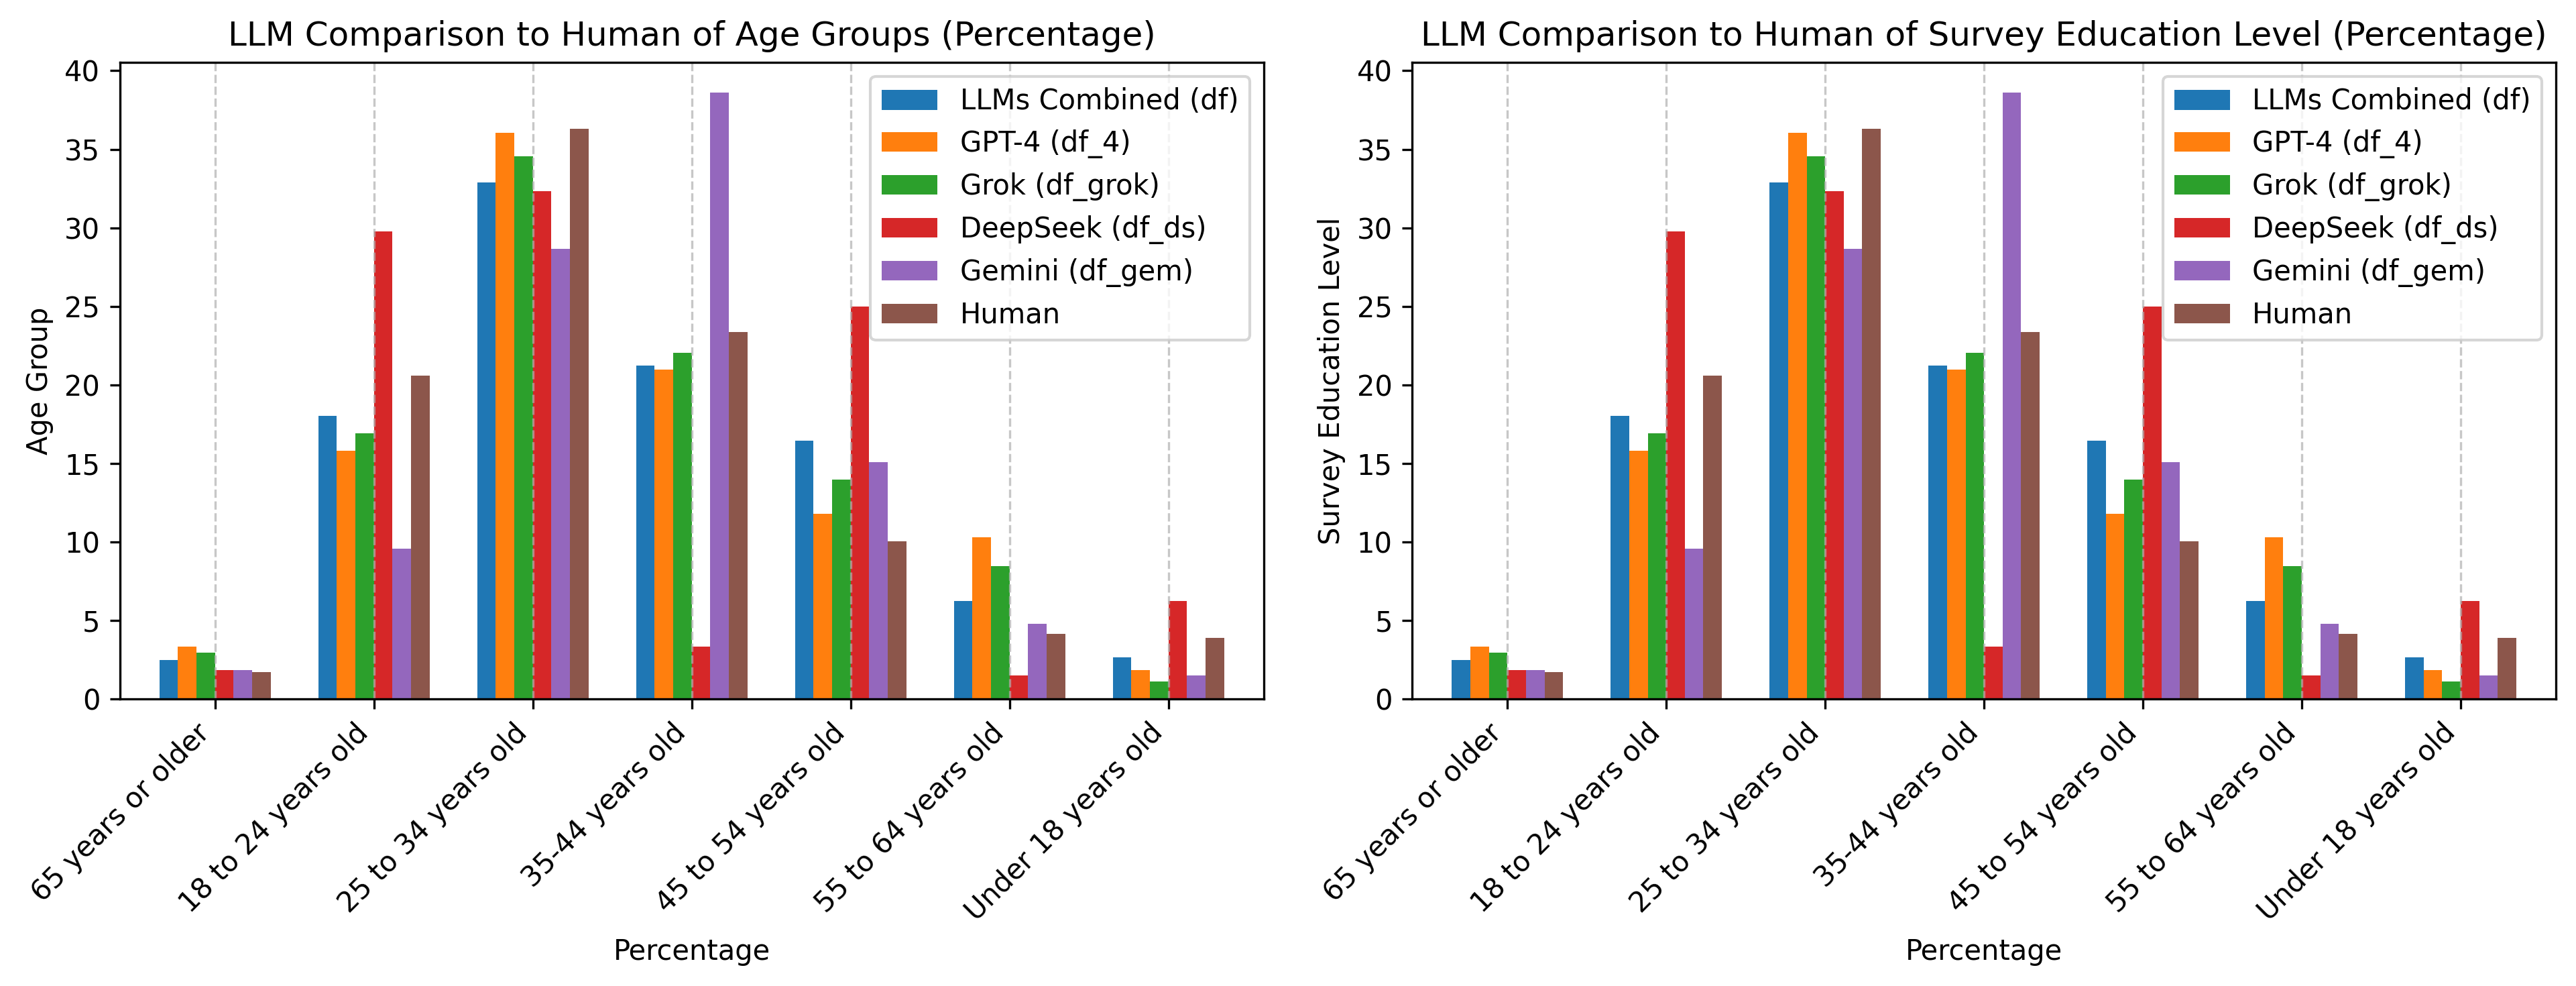

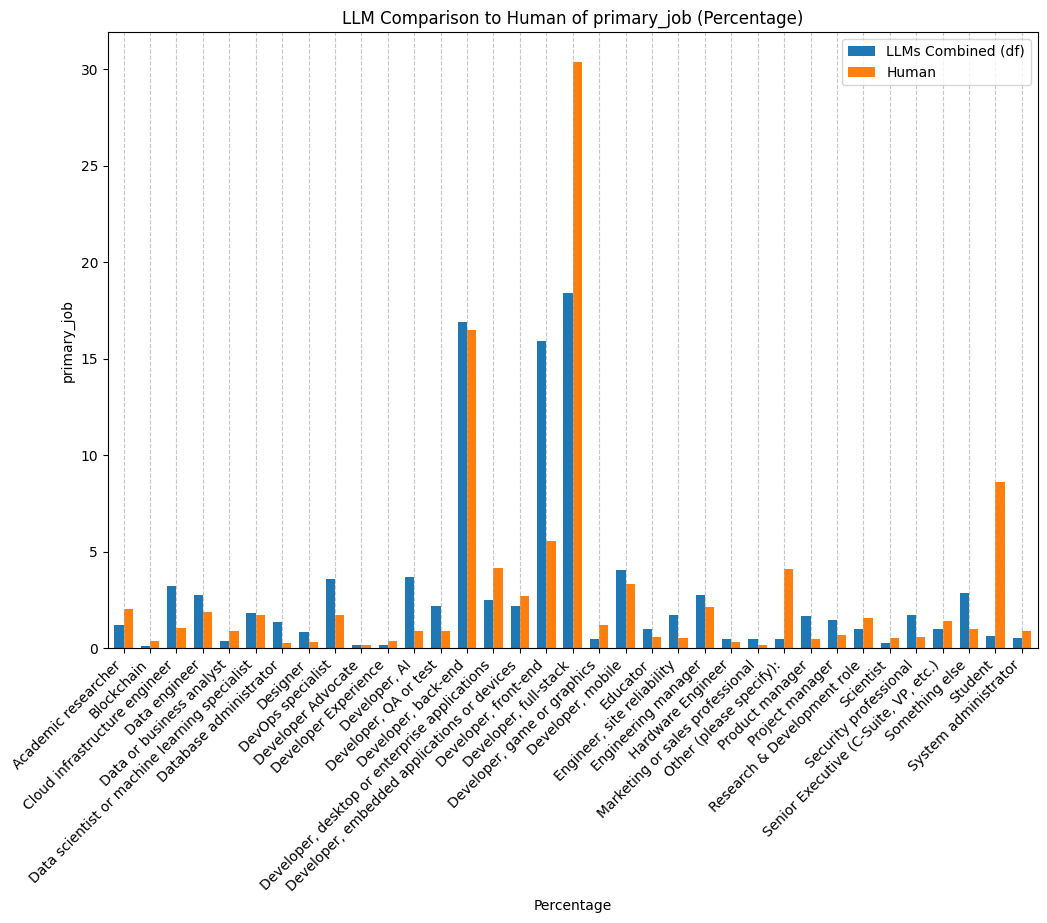

In [26]:
# Generate percentage value counts for all dataframes
df_all_counts = df_all['age_group'].value_counts(normalize=True) * 100
df_4_counts = df_4['age_group'].value_counts(normalize=True) * 100
df_grok_counts = df_grok['age_group'].value_counts(normalize=True) * 100
df_ds_counts = df_ds['age_group'].value_counts(normalize=True) * 100
df_gem_counts = df_gem['age_group'].value_counts(normalize=True) * 100
so_clean_counts = so_clean['age_group'].value_counts(normalize=True) * 100

# Combine all into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'LLMs Combined (df)': df_all_counts,
    'GPT-4 (df_4)': df_4_counts,
    'Grok (df_grok)': df_grok_counts,
    'DeepSeek (df_ds)': df_ds_counts,
    'Gemini (df_gem)': df_gem_counts,
    'Human': so_clean_counts
}).fillna(0)

# Create side-by-side subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), dpi=300)

# First plot: Age Group Comparison
comparison_df.plot(kind='bar', ax=axes[0], width=0.7)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Age Group')
axes[0].set_title('LLM Comparison to Human of Age Groups (Percentage)')
axes[0].grid(axis='x', linestyle='--', alpha=0.7)
axes[0].legend(loc='best')

# Second plot: Survey Education Level Comparison
comparison_df.plot(kind='bar', ax=axes[1], width=0.7)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].set_xlabel('Percentage')
axes[1].set_ylabel('Survey Education Level')
axes[1].set_title('LLM Comparison to Human of Survey Education Level (Percentage)')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)
axes[1].legend(loc='best')

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined figure
plt.show()

# Generate percentage value counts for all dataframes
df_all_counts = df_all['primary_job'].value_counts(normalize=True) * 100
df_4_counts = df_4['primary_job'].value_counts(normalize=True) * 100
df_grok_counts = df_grok['primary_job'].value_counts(normalize=True) * 100
df_ds_counts = df_ds['primary_job'].value_counts(normalize=True) * 100
df_gem_counts = df_gem['primary_job'].value_counts(normalize=True) * 100
so_clean_counts = so_clean['primary_job'].value_counts(normalize=True) * 100

# Combine all into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'LLMs Combined (df)': df_all_counts,
    # 'GPT-4 (df_4)': df_4_counts,
    # 'Grok (df_grok)': df_grok_counts,
    # 'DeepSeek (df_ds)': df_ds_counts,
    # 'Gemini (df_gem)': df_gem_counts,
    'Human': so_clean_counts
}).fillna(0)

fig, ax = plt.subplots(figsize=(12, 8))
comparison_df.plot(kind='bar', ax=ax, width=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.xlabel('Percentage')
plt.ylabel('primary_job')
plt.title('LLM Comparison to Human of primary_job (Percentage)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(loc='best')

plt.show()


Combined: 

Chi-Squared Test Results for 'age_group':
Chi2 Statistic: 24.537
Degrees of Freedom: 6
P-value: 0.000416

Chi-Squared Test Results for 'survey_education_level':
Chi2 Statistic: 37.523
Degrees of Freedom: 4
P-value: 1.41e-07

Chi-Squared Test Results for 'total_years_coding':
Chi2 Statistic: 114.068
Degrees of Freedom: 12
P-value: 9.35e-19

Chi-Squared Test Results for 'professional_coding_experience':
Chi2 Statistic: 242.047
Degrees of Freedom: 12
P-value: 6.22e-45

Chi-Squared Test Results for 'primary_job':
Chi2 Statistic: 294.747
Degrees of Freedom: 34
P-value: 2.63e-43

GPT-4: 

Chi-Squared Test Results for 'age_group':
Chi2 Statistic: 13.379
Degrees of Freedom: 6
P-value: 0.0374

Chi-Squared Test Results for 'survey_education_level':
Chi2 Statistic: 8.006
Degrees of Freedom: 4
P-value: 0.0913

Chi-Squared Test Results for 'total_years_coding':
Chi2 Statistic: 46.483
Degrees of Freedom: 12
P-value: 5.73e-06

Chi-Squared Test Results for 'professional_coding_experience'

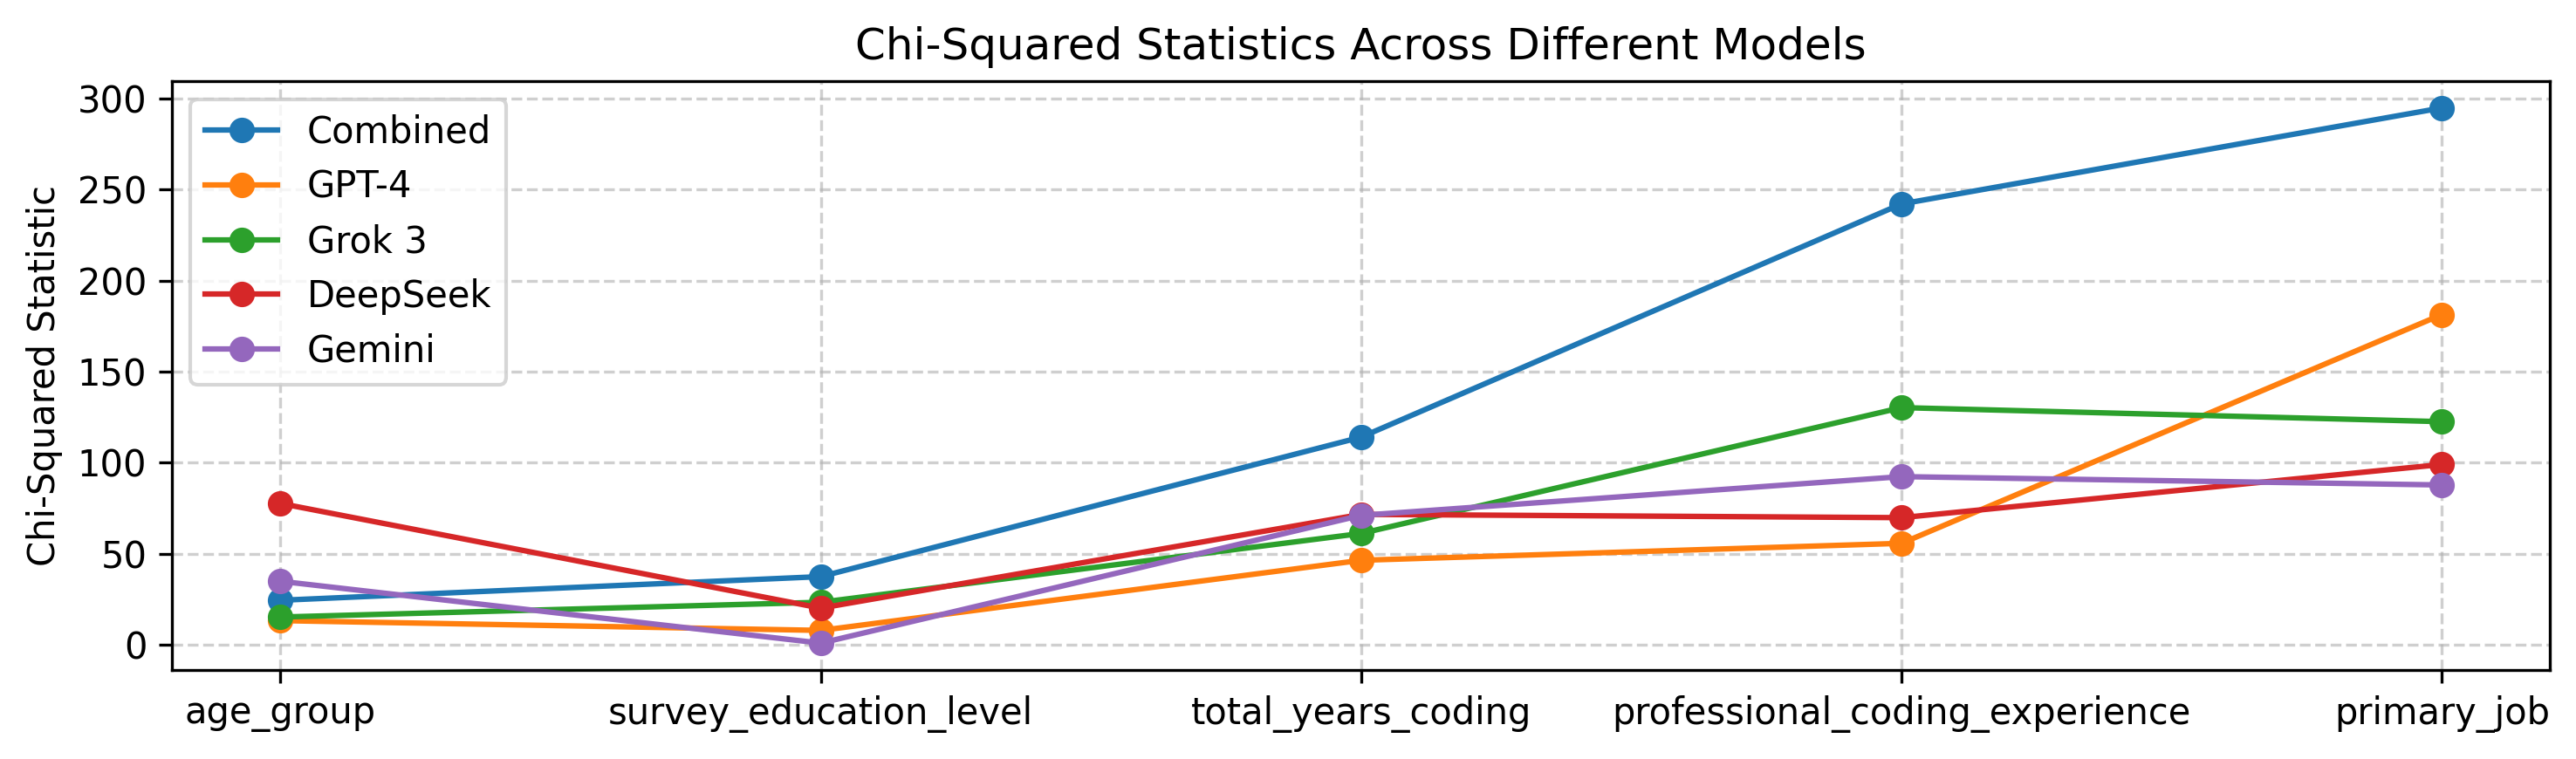

In [27]:
######################### RUN CHI SQUARED #########################

# List the categorical columns you want to test (ensure these columns exist in both DataFrames)
columns_to_test = [
    'age_group',
    'survey_education_level',
    'total_years_coding',
    'professional_coding_experience',
    'primary_job',
]

colums_with_list_values = ['online_resources', 'technical_documentation_sources', 'learning_methods']
chi2_results = {}

# Loop over the selected columns and perform the chi-squared test
print(f"\n{GREEN}Combined: {RESET}")
chi2_results["Combined"] = {col: chi_squared_test(col, df_all, df2_sampled) for col in columns_to_test}

# Compute chi-squared per model
for d in data_frames:
    if d.empty:
        continue

    model_name = d['model'].iloc[0]
    print(f"\n{GREEN}{model_name}: {RESET}")
    chi2_results[model_name] = {col: chi_squared_test(col, d, df2_sampled_272) for col in columns_to_test}

# Convert results to plot-friendly format
models = list(chi2_results.keys())
categories = columns_to_test

# Extract chi-squared statistics
chi2_values = {model: [chi2_results[model][cat][0] for cat in categories] for model in models}

# Plot line chart for chi-squared statistics
fig, ax = plt.subplots(figsize=(10, 3), dpi=300)

for model in models:
    ax.plot(categories, chi2_values[model], marker='o', linestyle='-', label=model)

ax.set_ylabel('Chi-Squared Statistic')
ax.set_title('Chi-Squared Statistics Across Different Models')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [28]:
# @title
# from scipy.stats import fisher_exact

# def chi_squared_test_lists(df1, df2, columns_with_lists):
#     """
#     Runs Chi-squared tests for categorical columns that store lists of values
#     by breaking them into individual occurrences and comparing distributions.
#     Uses Fisher's Exact Test for 2x2 cases.
#     """
#     for col in columns_with_lists:
#         if col in df1.columns and col in df2.columns:
#             # Extract all unique individual values from lists
#             unique_values = set(x for v in pd.concat([df1[col], df2[col]]).dropna() for x in (v if isinstance(v, list) else [v]))

#             # Create binary DataFrames to represent individual list elements
#             df1_expanded = pd.DataFrame({f"{col}_{val}": df1[col].apply(lambda x: int(val in x) if isinstance(x, list) else 0) for val in unique_values})
#             df2_expanded = pd.DataFrame({f"{col}_{val}": df2[col].apply(lambda x: int(val in x) if isinstance(x, list) else 0) for val in unique_values})

#             # Run Chi-squared or Fisher's Exact Test on the expanded columns
#             for value in unique_values:
#                 new_col = f"{col}_{value}"
#                 if new_col in df1_expanded.columns and new_col in df2_expanded.columns:
#                     contingency_table = pd.crosstab(df1_expanded[new_col], df2_expanded[new_col])

#                     # Check if all values are zero
#                     if contingency_table.sum().sum() == 0:
#                         print(f"⚠️ Skipping {new_col}: No occurrences in both datasets.")
#                         continue

#                     try:
#                         if contingency_table.shape == (2, 2):  # Use Fisher’s Exact Test for 2x2 tables
#                             oddsratio, p = fisher_exact(contingency_table)
#                             print(f"\nFisher's Exact Test for {col} -> {value}:")
#                             print(f"Odds Ratio: {oddsratio:.4f}, p-value: {p:.4f}")
#                         else:
#                             chi2, p, _, expected = chi2_contingency(contingency_table)

#                             # If expected frequencies are too low, group into "Other"
#                             if (expected < 5).sum() > 0:
#                                 print(f"\n⚠️ Warning: Chi-squared test might be invalid for {col} -> {value} (low expected counts).")
#                                 print(f"Chi2 Statistic: {chi2:.4f}, p-value: {p:.4f}")
#                             else:
#                                 print(f"\nChi-Squared Test for {col} -> {value}:")
#                                 print(f"Chi2 Statistic: {chi2:.4f}, p-value: {p:.4f}")

#                         if p < 0.05:
#                             print("→ Significant difference (Reject H0)")
#                         else:
#                             print("→ No significant difference (Fail to reject H0)")

#                     except Exception as e:
#                         print(f"⚠️ Error running Chi-squared test for {col} -> {value}: {e}")

# # Example usage:
# chi_squared_test_lists(df_all, df2_sampled, ['online_resources', 'technical_documentation_sources', 'learning_methods'])
